# Problem Statement

Credit Scoring [source](https://colab.research.google.com/drive/1OJSuXY6K2WZWeHt84bLq5Fx4KvqZ8gyc#scrollTo=9vhbjnDIQtp-&line=3&uniqifier=1)

# Importing Libraries and Data Collection

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB

from datetime import datetime
from tqdm import tqdm
import yaml
import joblib
import json
import copy
import hashlib

import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

PATH = "/root/ml_process_feb23/data/raw/"

credit_data = pd.read_csv(PATH + "AER_credit_card_data.csv")
credit_data

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


# Data Definition

In [4]:
# Check the DataFrame information
credit_data.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Columns: 12 entries, card to active
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [5]:
# Check the detailed DataFrame information
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


From the information shown above, I comprehend a general 
insight into the `credit_data`.






It has 1319 rows and 12 features, which consist of 9 numerical features, and 3 numerical categorical features.








In [6]:
# Check the features name
credit_data.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

Features definition:


*   `card`: Acceptance status of credit card application
*   `reports`: Number of major derogatory reports
*   `age`: Age, in years plus twelfths of a year
*   `income`: Yearly income (divided by 10,000)
*   `share`: Ratio of monthly credit card expenditure to yearly income
*   `expenditure`: Average monthly credit card expenditure
*   `owner`: Home ownership
*   `selfempl`: Self-employed status, "no" means an employee to a company
*   `dependents`: Number of dependents
*   `months`: Months living at current address
*   `majorcards`: Number of major credit cards held
*   `active`: Number of active credit accounts








# Data Validation

In [7]:
# Check the distribution of numerical features
credit_data.describe()

,reports,age,income,share,expenditure,dependents,months,majorcards,active
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,0.456406,33.213103,3.365376,0.068732,185.057071,0.993935,55.267627,0.817286,6.996967
std,1.345267,10.142783,1.693902,0.094656,272.218917,1.247745,66.271746,0.386579,6.305812
min,0.000000,0.166667,0.210000,0.000109,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.416670,2.243750,0.002316,4.583333,0.000000,12.000000,1.000000,2.000000
50%,0.000000,31.250000,2.900000,0.038827,101.298300,1.000000,30.000000,1.000000,6.000000
75%,0.000000,39.416670,4.000000,0.093617,249.035800,2.000000,72.000000,1.000000,11.000000
max,14.000000,83.500000,13.500000,0.906320,3099.505000,6.000000,540.000000,1.000000,46.000000


Notes on the numerical data.
*  The counts in the entire features are the same value, meaning that `credit_data` has no null value.
* The minimum age recorded is 2 months old, which is consciously impossible to apply for a credit card at that age.
* Applicant(s) who have zero expenditure will also be checked thoroughly later to make sure the data is correctly filled in.





In [8]:
# Check the distribution of categorical features
credit_data.describe(include=['O'])

,card,owner,selfemp
count,1319,1319,1319
unique,2,2,2
top,yes,no,no
freq,1023,738,1228


All the categorical features have the binary value, "yes" and "no".

# Data Splitting

In [9]:
# Import new library to store the new data as a pickle file
import joblib

pkl_folder = "/root/ml_process_feb23/data/processed/"

def split_input_output(dataset,
                       target_column,
                       save_file = True,
                       return_file = True):
    """Divide the data into its dependent variable/target (y-axis) and independent/predictor (x-axis) ones,
    and store the result data as a pickle file to smooth the pipeline"""

    
    output_df = dataset[target_column]
    input_df = dataset.drop([target_column],
                            axis = 1)

    
    if save_file:  
        joblib.dump(output_df, pkl_folder + "output_df.pkl")
        joblib.dump(input_df, pkl_folder + "input_df.pkl")
    
    if return_file:
        return output_df, input_df


def split_train_test(x, y, TEST_SIZE):
    """Split the data into the training and test data,
    stratify parameter is activated,
    this function will be reproduced later as the data-splitting process further"""
    
    x_train, x_test,\
        y_train, y_test = train_test_split(x,
                                           y,
                                           test_size=TEST_SIZE,
                                           random_state=46,
                                           stratify=y)

    return x_train, x_test, y_train, y_test

def split_data(data_input, data_output, return_file=False, TEST_SIZE=0.17):
    """Split the data into the training, validation and test data,
    both the validation and test data are split from the training data,
    and store the result data as a pickle file to smooth the pipeline"""

    x_train, x_test, \
        y_train, y_test = split_train_test(
            data_input,
            data_output,
            TEST_SIZE)

    x_train, x_valid, \
        y_train, y_valid = split_train_test(
            x_train,
            y_train,
            TEST_SIZE)
    
    joblib.dump(x_train, pkl_folder + "x_train.pkl")
    joblib.dump(y_train, pkl_folder + "y_train.pkl")
    joblib.dump(x_valid, pkl_folder + "x_valid.pkl")
    joblib.dump(y_valid, pkl_folder + "y_valid.pkl")
    joblib.dump(x_test, pkl_folder + "x_test.pkl")
    joblib.dump(y_test, pkl_folder + "y_test.pkl")

    if return_file:
        return x_train, y_train, \
            x_valid, y_valid, \
            x_test, y_test

In [10]:
# Define the parameter
TARGET = "card"

# Execute the data-splitting functions
output_df, input_df = split_input_output(credit_data,
                                        TARGET, 
                                        save_file = False)

x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(input_df,
                                                               output_df,
                                                               True)

The "credit" feature in `credit_data` is set as the dependent variable (saved as output_df), while the rest features are the independent variables (saved as input_df).

In [11]:
# Recheck the division of the dependent and independent variables from the `credit_data`
print(f'The dependent variable (target):\n{output_df} \n')
print("-------------------------------------\n")
print(f'The independent variables (predictors):\n {input_df}')

The dependent variable (target):
0       yes
1       yes
2       yes
3       yes
4       yes
       ... 
1314    yes
1315     no
1316    yes
1317    yes
1318    yes
Name: card, Length: 1319, dtype: object 

-------------------------------------

The independent variables (predictors):
       reports       age  income     share  expenditure owner selfemp  \
0           0  37.66667  4.5200  0.033270   124.983300   yes      no   
1           0  33.25000  2.4200  0.005217     9.854167    no      no   
2           0  33.66667  4.5000  0.004156    15.000000   yes      no   
3           0  30.50000  2.5400  0.065214   137.869200    no      no   
4           0  32.16667  9.7867  0.067051   546.503300   yes      no   
...       ...       ...     ...       ...          ...   ...     ...   
1314        0  33.58333  4.5660  0.002146     7.333333   yes      no   
1315        5  23.91667  3.1920  0.000376     0.000000    no      no   
1316        0  40.58333  4.6000  0.026513   101.298300   yes     

Both the `input_df` and `output_df` are split into three data that will be used for training, validation, and testing the model.

The training data has the majority proportion.

In [12]:
# Inspect the data-splitting result
print(f"input_df shape: {input_df.shape}")
print(f"x_train shape: {x_train.shape}")
print(f"x_valid shape:{x_valid.shape}")
print(f"x_test shape: {x_test.shape}\n")
print("-------------------------------------\n")
print(f"output_df shape: {output_df.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"y_test shape: {y_test.shape}")


input_df shape: (1319, 11)
x_train shape: (908, 11)
x_valid shape:(186, 11)
x_test shape: (225, 11)

-------------------------------------

output_df shape: (1319,)
y_train shape: (908,)
y_valid shape: (186,)
y_test shape: (225,)


The stratified splitting method applies to the `output_df` to keep the value proportion approximately the same.

In [13]:
# Recheck the data stratification
print(f"y_train value proportion\n{y_train.value_counts(normalize = True)}")
print("-------------------------------------\n")
print(f"y_valid value proportion\n{y_valid.value_counts(normalize = True)}")
print("-------------------------------------\n")
print(f"y_test value proportion\n{y_test.value_counts(normalize = True)}")

y_train value proportion
yes    0.77533
no     0.22467
Name: card, dtype: float64
-------------------------------------

y_valid value proportion
yes    0.774194
no     0.225806
Name: card, dtype: float64
-------------------------------------

y_test value proportion
yes    0.777778
no     0.222222
Name: card, dtype: float64


# Exploratory Data Analysis (EDA)

## Inspecting the data distribution.

The EDA works are applied only for the training data.

In [14]:
# Concatenate the x_train and y_train for EDA.
EDA_df = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)
joblib.dump(EDA_df, pkl_folder + "EDA_df.pkl")

# Separate the numerical and categorical data types
numerical_columns = EDA_df._get_numeric_data().columns
categorical_columns = (EDA_df.drop(numerical_columns, axis=1)).columns.values.tolist()

In [15]:
# Create the function for data visualization.
def draw_histograms(EDA_df, features, n_rows, n_cols, bins):
    """A function to visualize the multiple graphs of the features
    for an introductory observation to the dataset"""
    fig = plt.figure()
    for i, var_name in enumerate(features):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        EDA_df[var_name].hist(bins = bins, ax=ax, color = 'green', figsize = (50, 50))
        ax.set_title(var_name, fontsize = 50)
        ax.tick_params(labelsize = 40, grid_alpha = 0.7)
    fig.tight_layout() 
    plt.show()

### Numerical Data Distribution.

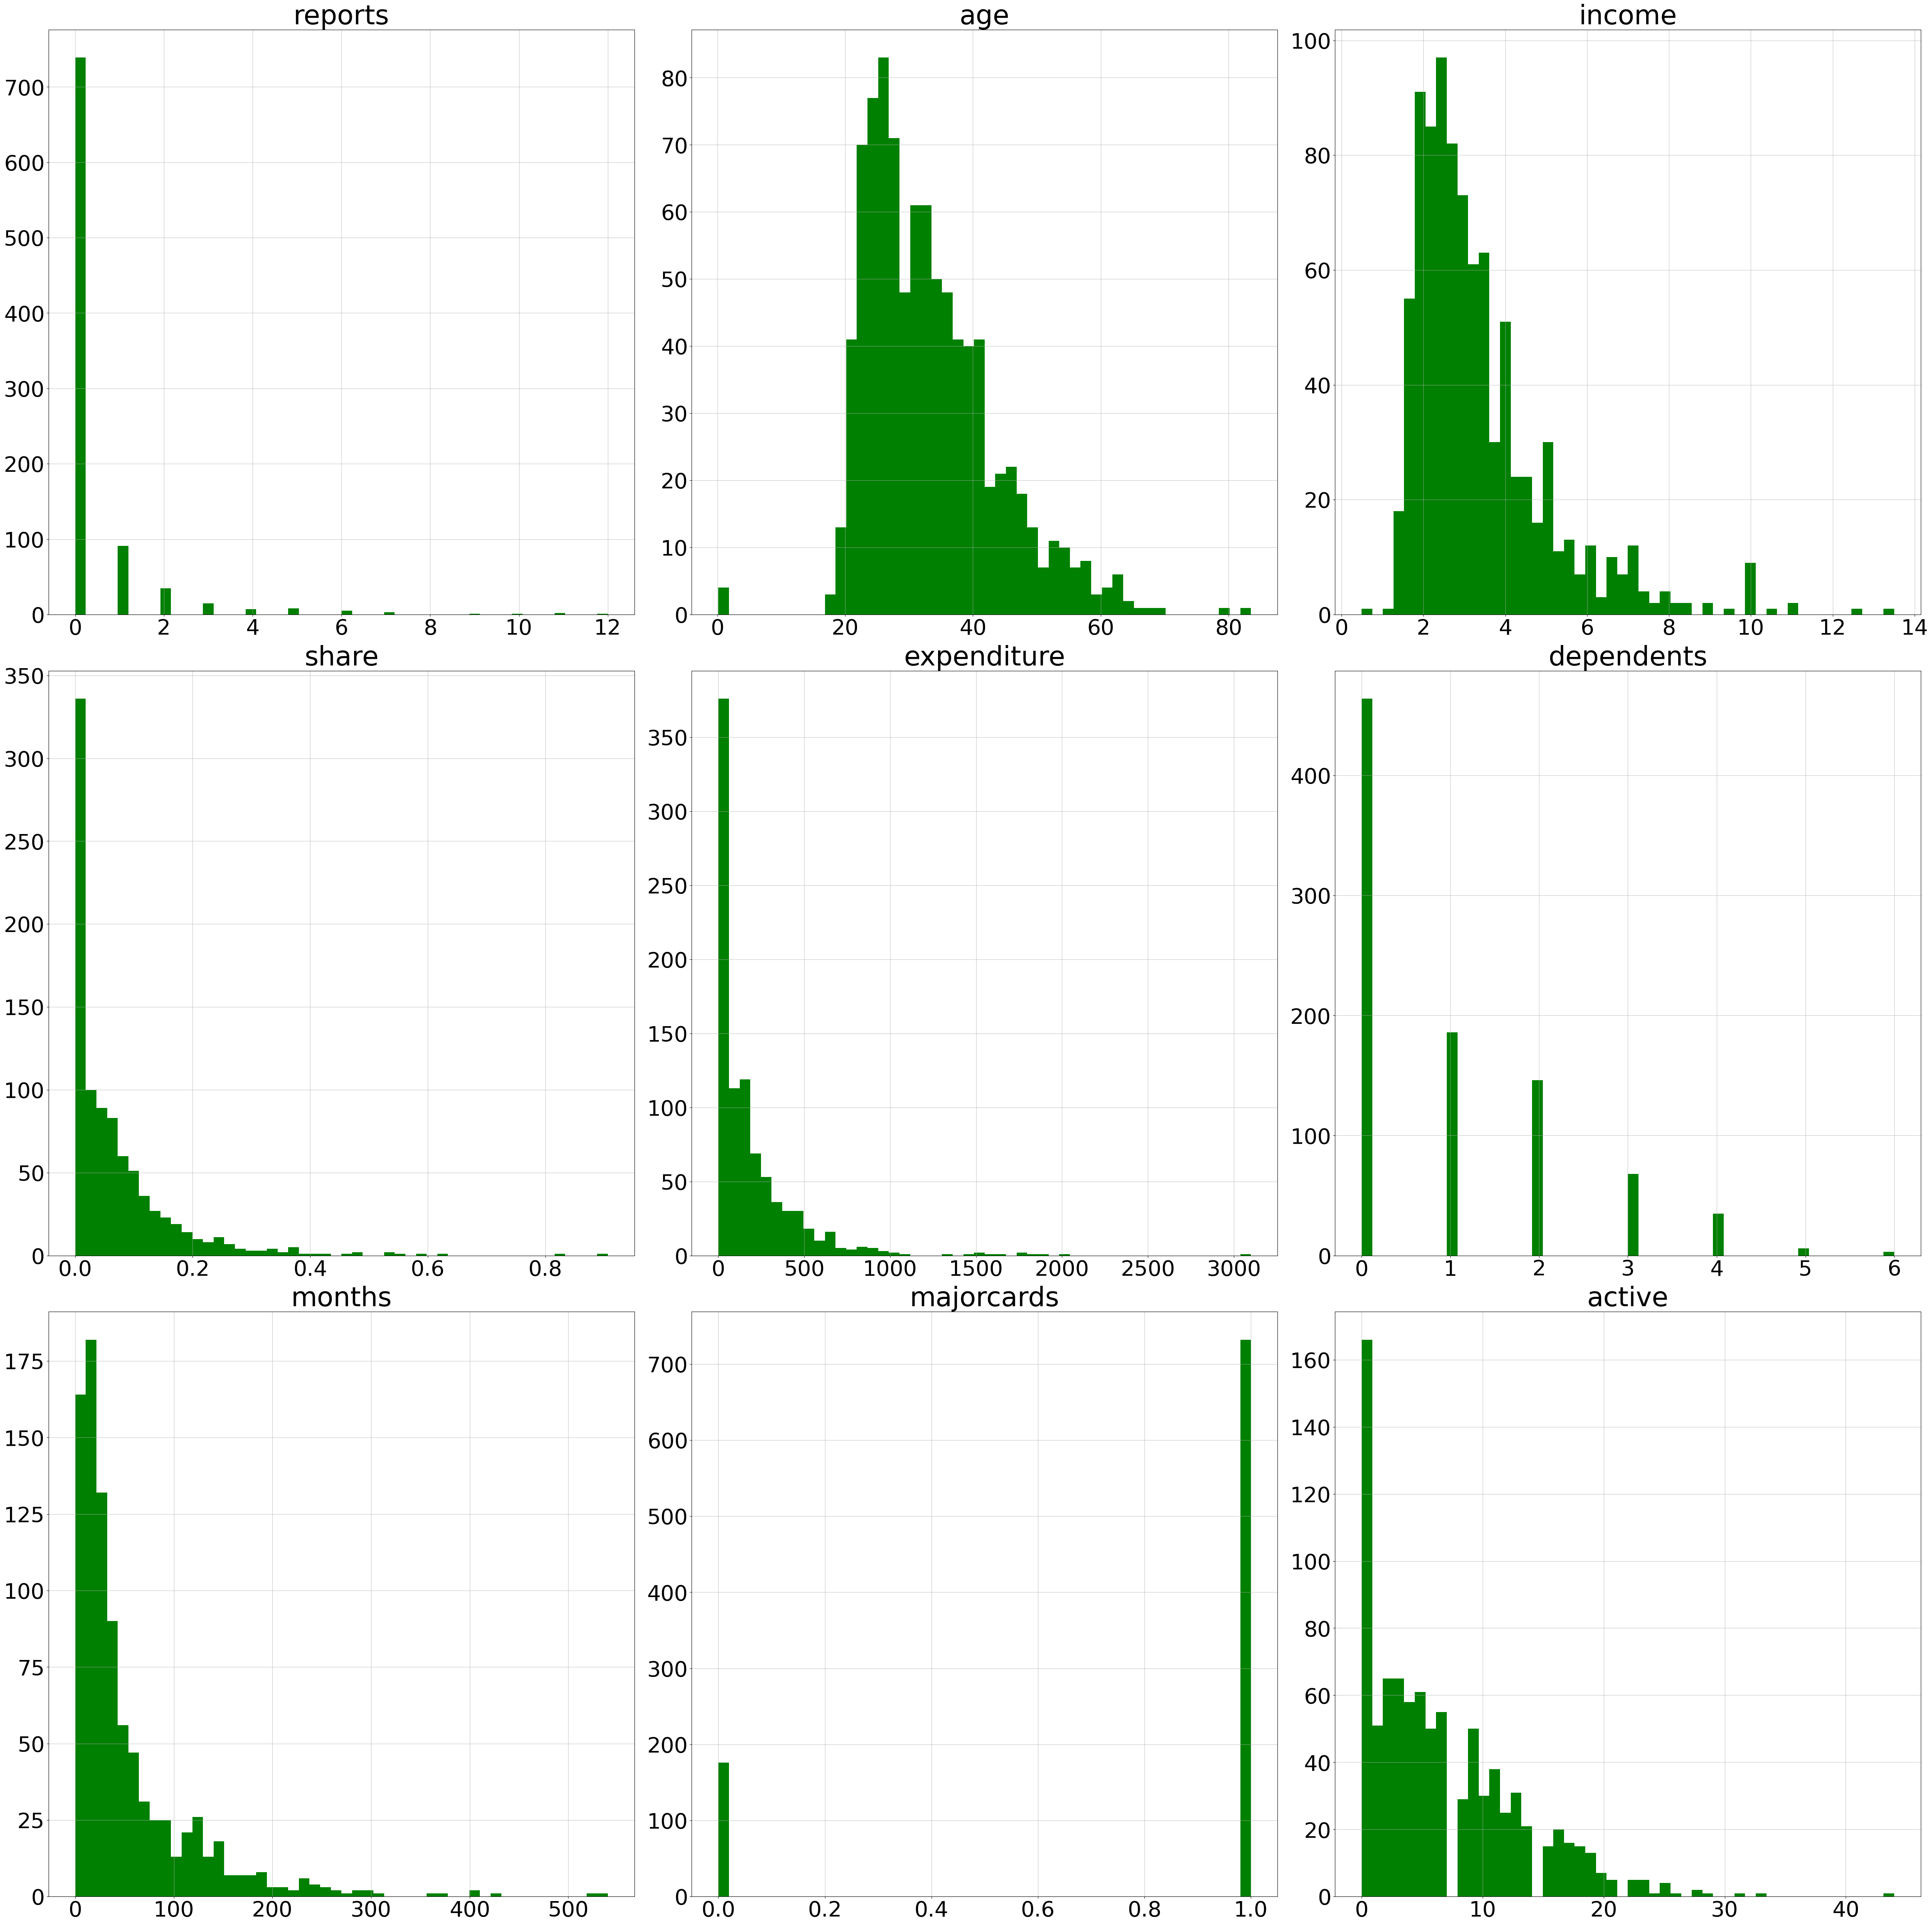

In [16]:
# Visualize the numerical data distribution
draw_histograms(EDA_df, numerical_columns, 3, 3, 50)

Next, I will analyze deeper into the numerical columns.

#### Detail EDA on each feature.

In [17]:
# Create the function for specific numerical column data visualization.
def check_dist(col, bins=50, density=False, plot_normal=True, log_bins=False):
  """A function to visualize the graph for inspecting each feature thoroughly,
  in addition to the basic bar plot of the feature, the graph also shows the normal distribution curve, mean and median vertical lines.
  The correlation to the dependent/target feature is visualized by the KDE plot."""

  x = EDA_df[col]
  TARGET = EDA_df['card']

  fig, ax = plt.subplots(figsize=(8,6))
  fig.suptitle(f"Distribution of {str(col).upper()}")
  sns.distplot(x, axlabel=x.name, color = "green")
  sns.kdeplot(EDA_df.loc[TARGET == "yes", col] , label = 'Approved')
  sns.kdeplot(EDA_df.loc[TARGET == "no", col] ,  label = 'Not Approved')
  line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
  line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
  first_legend = plt.legend(handles=[line1,line2], loc=1)

  if plot_normal == True:
    mu, std = stats.norm.fit(x)
    xmin, xmax = plt.xlim()
    x_norm = np.linspace(xmin, xmax, 100)
    pdf = stats.norm.pdf(x_norm, mu, std)
    ax.plot(x_norm, pdf, 'k', linewidth=2, label=f"normal distribution\n(mu=mean, std:{std:.2f}")

  ax.legend()
  fig.show()
  print(x.describe())
  print("Median:", x.median())

##### reports

count    908.000000
mean       0.416300
std        1.248875
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       12.000000
Name: reports, dtype: float64
Median: 0.0


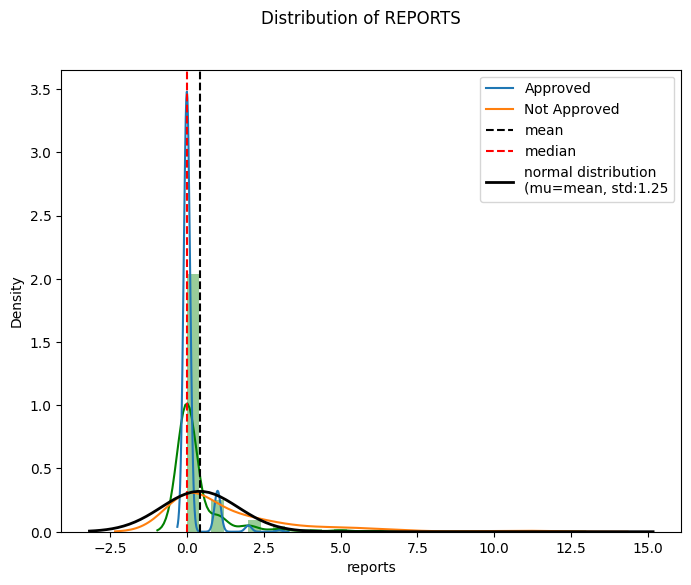

In [18]:
check_dist(numerical_columns[0])

Most applicants have no major derogatory reports.

##### age

count    908.000000
mean      33.231736
std       10.237244
min        0.166667
25%       25.333330
50%       31.250000
75%       38.937503
max       83.500000
Name: age, dtype: float64
Median: 31.25


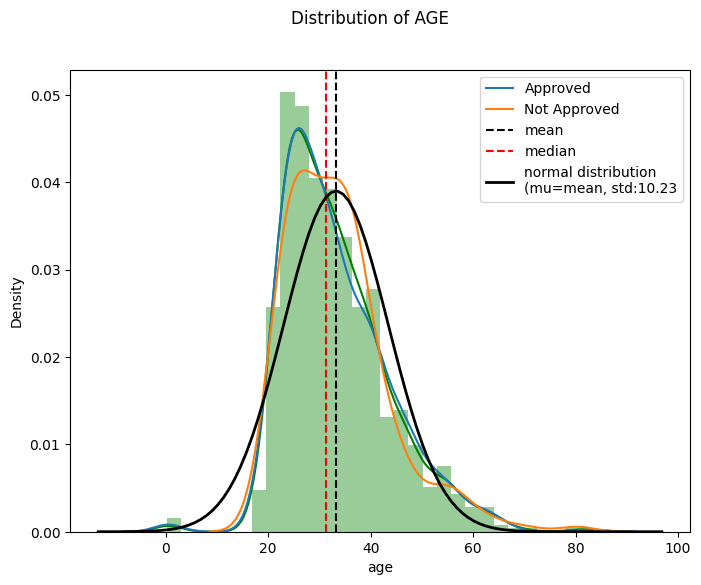

In [19]:
check_dist(numerical_columns[1])

I have a suspicion about the occurrence of applicants' age that is near 0 (zero) and the gap between 0 and 20.

To comprehend it, I need to find those data.

In [20]:
# Check the data of the applicants who are near zero in age 
print("The applicants' age near zero")
EDA_df.loc[EDA_df['age'] < 1]


The applicants' age near zero


,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,card
298,0,0.583333,4.00,0.072664,242.1283,yes,no,3,24,1,4,yes
551,0,0.166667,3.24,0.184366,497.7058,yes,no,3,25,1,16,yes
597,0,0.583333,2.50,0.083171,173.0233,no,no,0,150,1,5,yes
728,0,0.750000,1.60,0.154191,205.2542,no,no,0,1,1,9,yes


In [21]:
print("The applicants' age under 18")
EDA_df.loc[EDA_df['age'] < 18]

The applicants' age under 18


,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,card
298,0,0.583333,4.00,0.072664,242.1283,yes,no,3,24,1,4,yes
551,0,0.166667,3.24,0.184366,497.7058,yes,no,3,25,1,16,yes
597,0,0.583333,2.50,0.083171,173.0233,no,no,0,150,1,5,yes
728,0,0.750000,1.60,0.154191,205.2542,no,no,0,1,1,9,yes


From the table shown above, the data valued under 18 (the legal age to have a credit card) are the exact same with the data valued near zero, I conclude that the applicants whose ages are near zero are irrelevant and thus can be excluded from the data and will be dropped later.

##### income

count    908.000000
mean       3.383281
std        1.694995
min        0.490000
25%        2.250000
50%        3.000000
75%        4.000000
max       13.500000
Name: income, dtype: float64
Median: 3.0


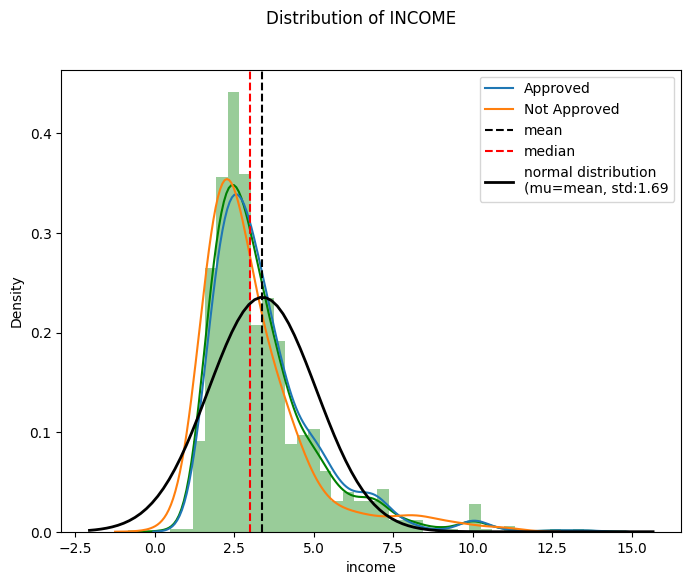

In [22]:
check_dist(numerical_columns[2])

The values shown in this feature are divided by 10,000.

There are some notable occurrence of applicants whose incomes are around 10, we need to inspect it further.

In [23]:
EDA_df.loc[(EDA_df['income'] >= 10)]


,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,card
11,0,45.58333,13.5000,0.010311,115.41670,yes,no,2,126,1,9,yes
127,0,51.58333,12.4999,0.297555,3099.50500,yes,no,1,120,1,21,yes
151,0,43.66667,10.0393,0.021863,182.82500,yes,no,1,12,1,18,yes
280,0,53.00000,11.0000,0.000109,0.00000,yes,yes,0,429,1,0,no
343,0,32.58333,10.0000,0.099808,831.73170,yes,no,3,7,1,28,yes
518,0,47.33333,10.4000,0.230948,2001.54700,yes,no,2,9,0,0,yes
535,1,32.50000,10.0000,0.037040,308.25000,yes,no,3,35,1,4,yes
802,0,31.75000,10.9999,0.010701,97.42416,no,no,0,12,1,0,yes
813,2,46.00000,10.0320,0.010134,84.39083,yes,no,2,134,1,15,yes


The higher income means the more probable the application to be approved.

Moreover, the applicant's income is more than $100,000 per year, the probability of an application being approved is near 100%.

We can see the exception at the table above, the only one applicant whose income more than $100,000 per year and not approved have zero expenditure.

I decide to keep all the data in this feature, perhaps the model will the threshold of approval decision at 10 or there will be any significant weight from another feature that can affect the approval decision.

##### share

count    908.000000
mean       0.069351
std        0.095898
min        0.000109
25%        0.002443
50%        0.038775
75%        0.094165
max        0.906320
Name: share, dtype: float64
Median: 0.038775409999999996


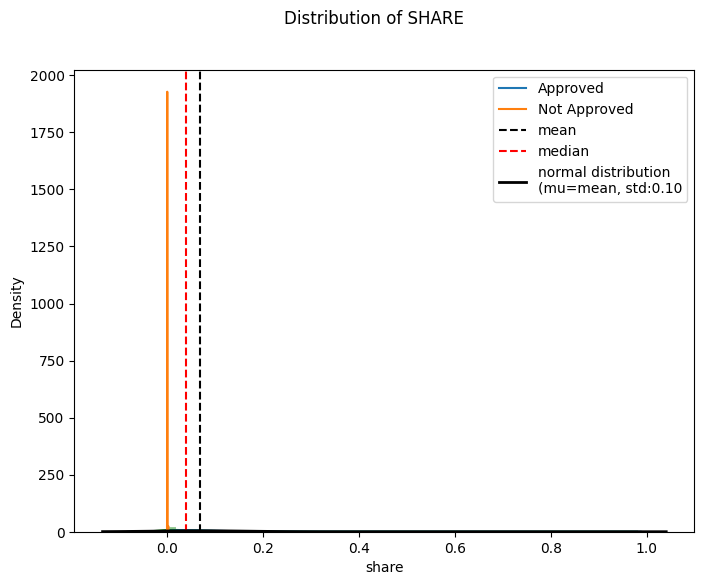

In [24]:
check_dist(numerical_columns[3])

Since I do not get a clear comprehension of the graph, I use the statistical data distribution information to inspect this feature.

Let's inspect the approval proportion from every quartile in this feature.

In [25]:
print(f"The approval proportion of Q4 data: \n{EDA_df.loc[(EDA_df['share'] >= 0.094165)].card.value_counts(normalize=True)}")
print("-------------------------------------\n")
print(f"The approval proportion of Q3 data: \n{EDA_df.loc[(EDA_df['share'] >= 0.0387775) | (EDA_df['share'] <= 0.094165)].card.value_counts(normalize=True)}")
print("-------------------------------------\n")
print(f"The approval proportion of Q1 and Q2 data: \n{EDA_df.loc[(EDA_df['share'] <= 0.0387775)].card.value_counts(normalize=True)}")
print("-------------------------------------\n")
print(f"The approval proportion of the entire training data: \n{EDA_df.card.value_counts(normalize=True)}")

The approval proportion of Q4 data: 
yes    1.0
Name: card, dtype: float64
-------------------------------------

The approval proportion of Q3 data: 
yes    0.77533
no     0.22467
Name: card, dtype: float64
-------------------------------------

The approval proportion of Q1 and Q2 data: 
yes    0.550661
no     0.449339
Name: card, dtype: float64
-------------------------------------

The approval proportion of the entire training data: 
yes    0.77533
no     0.22467
Name: card, dtype: float64


The higher proportion of income spent via credit card means the more probable the application to be approved.

Moreover, if credit card expenditure is more than 9.4165% of income, the probability of an application being approved is 100%.

I decide to keep all the data in this feature, perhaps the model will set the threshold of approval decision at 0.094165 or there will be any significant weight from another feature that can affect the approval decision.



##### expenditure

count     908.000000
mean      187.984463
std       277.174471
min         0.000000
25%         5.567708
50%       103.152500
75%       250.770800
max      3099.505000
Name: expenditure, dtype: float64
Median: 103.1525


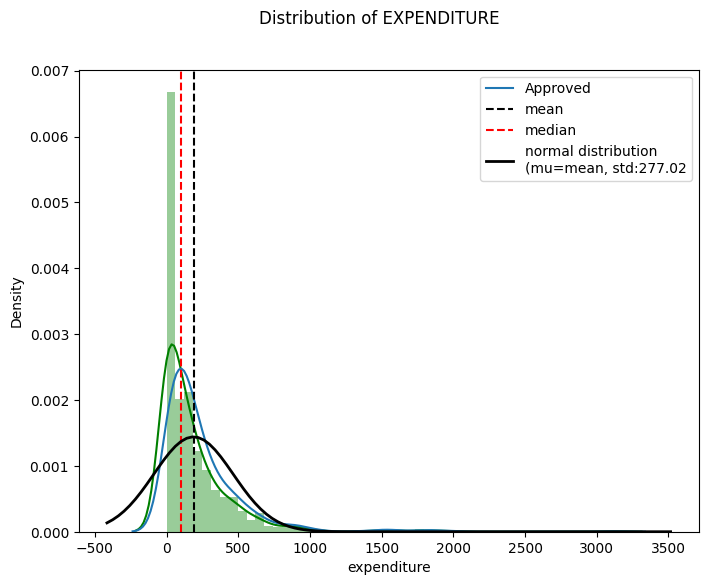

In [26]:
check_dist(numerical_columns[4])

Let's check the applicants with zero expenditure.

In [27]:
print(f"The approval proportion zero expenditure applicants: \n{EDA_df.loc[(EDA_df['expenditure'] == 0)].card.value_counts(normalize=True)}")

The approval proportion zero expenditure applicants: 
no     0.940092
yes    0.059908
Name: card, dtype: float64


Most of them are not approved to have the credit card.

Let's check the minority ones, the approved applicants.

In [28]:
EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'yes')]

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,card
22,0,29.08333,2.2000,0.000545,0.0,no,no,0,9,1,0,yes
51,0,32.00000,2.4000,0.000500,0.0,no,no,1,11,1,8,yes
81,0,53.50000,1.5000,0.000800,0.0,yes,no,0,57,0,6,yes
126,0,19.83333,3.0000,0.000400,0.0,no,no,0,49,1,3,yes
157,0,23.00000,2.9000,0.000414,0.0,no,no,1,12,1,0,yes
301,0,29.00000,2.7000,0.000444,0.0,no,no,0,24,1,20,yes
321,0,23.75000,1.5678,0.000765,0.0,yes,no,1,6,1,0,yes
374,0,46.75000,2.8000,0.000429,0.0,yes,no,1,84,1,2,yes
505,0,44.66667,2.4000,0.000500,0.0,no,no,0,36,1,11,yes
525,0,49.16667,1.7000,0.000706,0.0,no,no,1,14,0,6,yes


From the table above, they are dominantly not self-employed and already held a credit card.

Perhaps the selfemp and majorcards features are decisive for the applicants with zero expenditure.

To prove it, let's observe the comparison between the approved and the not-approved ones.



In [29]:
print("Approved applicants\n")
print(f"Self-employed status: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'yes')].selfemp.value_counts(normalize=True)}\n")
print(f"major credit cards ownership: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'yes')].majorcards.value_counts(normalize=True)}")
print("_________________________________\n")
print("Not-Approved applicants\n")
print(f"Self-employed status: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'no')].selfemp.value_counts(normalize=True)}\n")
print(f"major credit cards ownership: \n{EDA_df.loc[(EDA_df['expenditure'] == 0) & (EDA_df['card'] == 'no')].majorcards.value_counts(normalize=True)}")

Approved applicants

Self-employed status: 
no     0.923077
yes    0.076923
Name: selfemp, dtype: float64

major credit cards ownership: 
1    0.769231
0    0.230769
Name: majorcards, dtype: float64
_________________________________

Not-Approved applicants

Self-employed status: 
no     0.906863
yes    0.093137
Name: selfemp, dtype: float64

major credit cards ownership: 
1    0.715686
0    0.284314
Name: majorcards, dtype: float64


There is no significant difference, so the `selfemp` and `majorcards` features are not the major decisive detail.

I am determined to keep the zero expenditures data for the training process.

##### dependents

count    908.000000
mean       0.958150
std        1.227402
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        6.000000
Name: dependents, dtype: float64
Median: 0.0


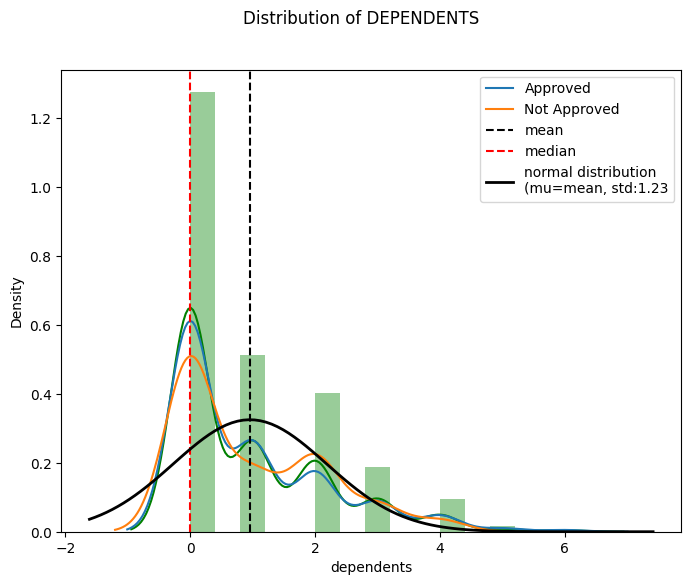

In [30]:
check_dist(numerical_columns[5])

Simply by reading the kdeplot of the approval decision, we can see that the probability of approved application is higher in every value of dependents, except in value 2.

Let's check the approval probability for the applicants in the highest quartile data, who have more than 2 dependents:




In [31]:

print(EDA_df.loc[(EDA_df['dependents'] > 2)].dependents.value_counts()\
                                            .rename_axis('number of dependents')\
                                            .to_frame('counts'))
print("_________________________________\n")
print("Approval decision for applicants with more than 2 dependents")
counts = EDA_df.loc[EDA_df['dependents'] >2].card.value_counts()
counts.name = 'counts'
approval = EDA_df.loc[EDA_df['dependents'] >2].card.value_counts(normalize=True)
approval.name = '%'
approval = (approval*100).round(2)
pd.concat([approval, counts], axis=1)


                      counts
number of dependents        
3                         68
4                         35
5                          6
6                          3
_________________________________

Approval decision for applicants with more than 2 dependents


,%,counts
yes,79.46,89
no,20.54,23


In [32]:
print("Approval proportion of the entire training data")
counts = EDA_df.card.value_counts()
counts.name = 'counts'
approval = EDA_df.card.value_counts(normalize=True)
approval.name = '%'
approval = (approval*100).round(2)
pd.concat([approval, counts], axis=1)


Approval proportion of the entire training data


,%,counts
yes,77.53,704
no,22.47,204


The applicants with more than 2 dependants even have higher possibility to be approved than the entire training data, thus I assume that the `dependents` feature are not the major decisive detail, and will keep it for the training process.

##### months

count    908.000000
mean      53.778634
std       65.321278
min        0.000000
25%       12.000000
50%       30.000000
75%       70.500000
max      540.000000
Name: months, dtype: float64
Median: 30.0


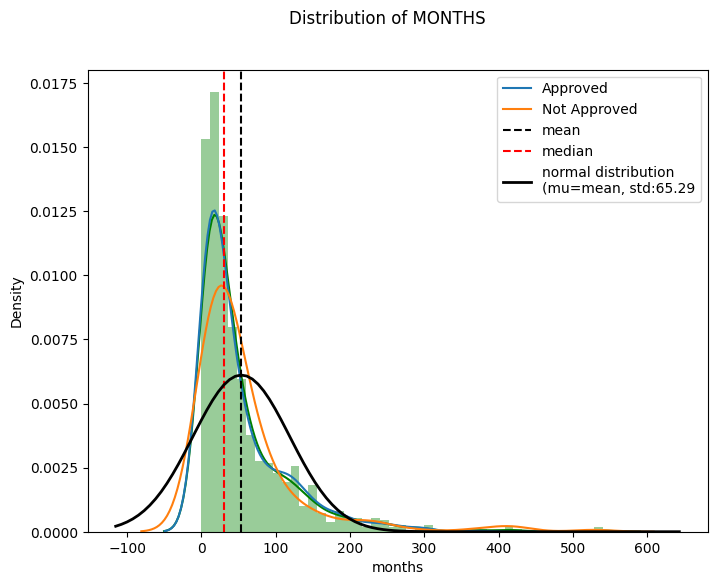

In [33]:
check_dist(numerical_columns[6])

This feature has a very wide range, let's inspect further the far distributed data to specify the outlier.

I roughly set the boundary at value 275.

In [34]:
EDA_df.loc[(EDA_df['months'] > 275)]

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,card
68,0,69.75000,1.8000,0.000667,0.0000,yes,no,0,528,0,5,no
79,1,56.75000,8.0000,0.000150,0.0000,yes,no,0,408,1,7,no
280,0,53.00000,11.0000,0.000109,0.0000,yes,yes,0,429,1,0,no
313,1,55.33333,3.7000,0.052201,160.4517,yes,no,1,300,1,4,yes
331,1,53.66667,4.1800,0.000287,0.0000,no,no,1,288,1,2,no
333,0,49.16667,5.2000,0.146526,634.8625,yes,no,1,303,1,11,yes
393,2,34.83333,4.9000,0.000245,0.0000,no,no,2,408,1,3,no
469,0,47.41667,4.9200,0.044894,183.8983,yes,yes,1,288,1,14,yes
544,0,55.16667,6.7000,0.038585,214.9342,yes,no,1,300,1,13,yes
656,1,56.91667,3.4838,0.062895,182.0958,yes,no,0,540,1,7,yes


There are 12 applicants whose value is more than 275, with 6 of them were approved to have the credit card.

The approved applicants perfectly correlated with the `expenditure` instead of `months`, all applicants with zero expenditure are not approved to have the credit card.

I decide to keep them for the training process.

##### majorcards

count    908.000000
mean       0.806167
std        0.395517
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: majorcards, dtype: float64
Median: 1.0


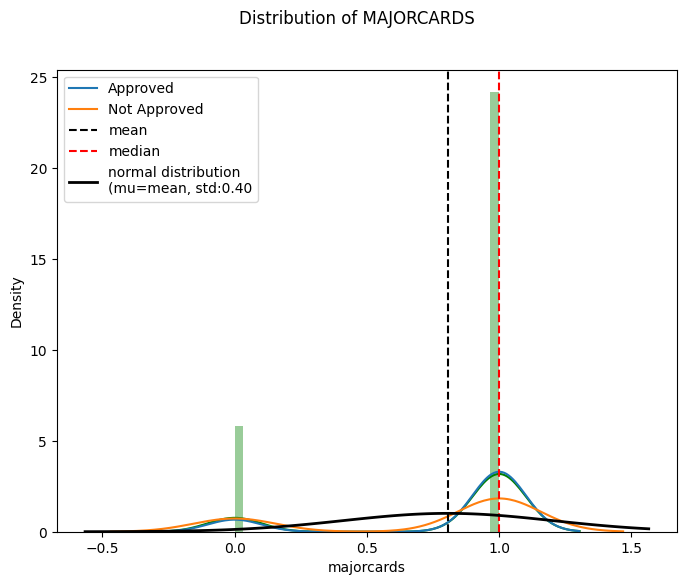

In [35]:
check_dist(numerical_columns[7])

Most applicants already have a credit card.

##### active

count    908.000000
mean       6.764317
std        6.269012
min        0.000000
25%        2.000000
50%        5.000000
75%       11.000000
max       44.000000
Name: active, dtype: float64
Median: 5.0


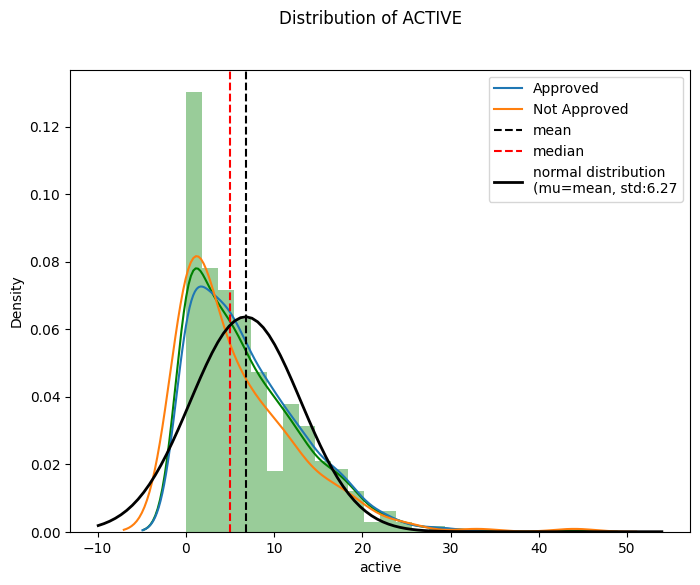

In [36]:
check_dist(numerical_columns[8])

Most applicants have no active credit accounts.

### Categorical Data Distribution.

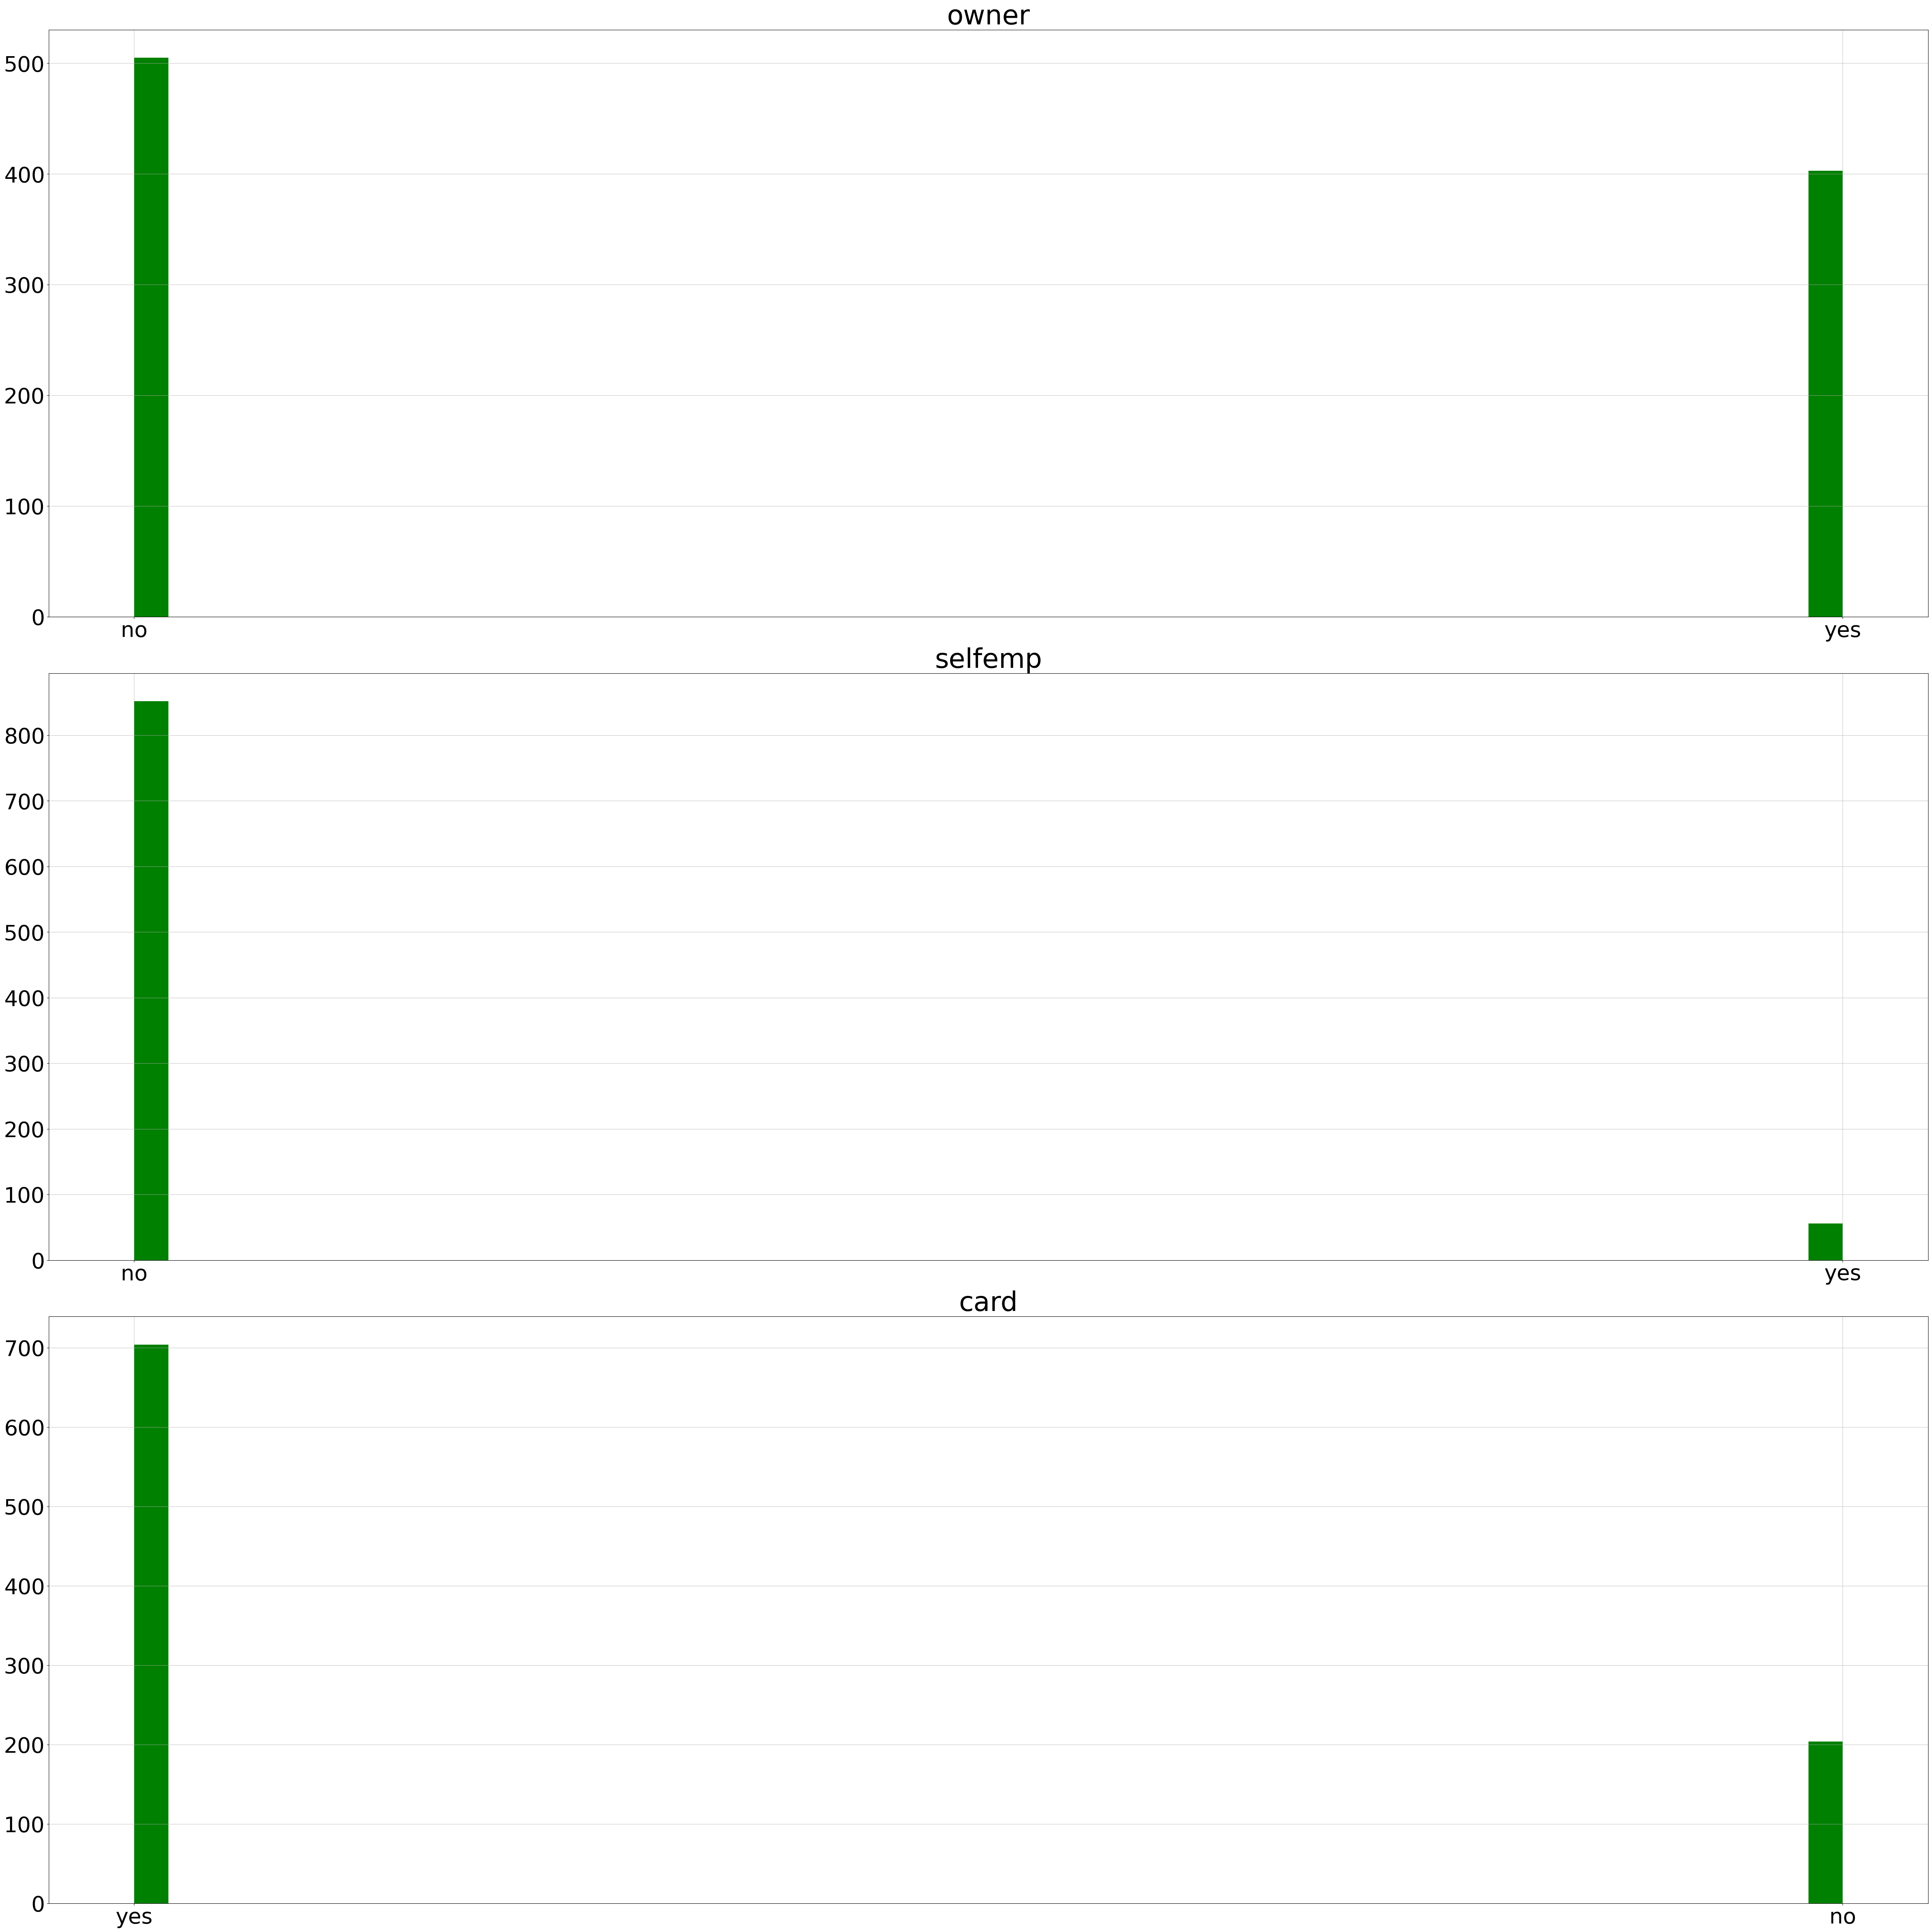

In [37]:
# Visualize the categorical data distribution
draw_histograms(EDA_df, categorical_columns, 3, 1, 50)

Next, I will analyze deeper into the categorical columns.

#### Detail EDA on each feature.

Since all categorical features are binary, so I will observe the correlation of each feature to the `card` feature.

##### owner

In [38]:
# Check the ditribution and percentage of `owner` feature
print(f"Applicants' home ownership distribution\n{EDA_df['owner'].value_counts()}")
print("-------------------------------------\n")
print(f"Applicants' home ownership percentage\n{EDA_df['owner'].value_counts(normalize = True)*100}")

Applicants' home ownership distribution
no     505
yes    403
Name: owner, dtype: int64
-------------------------------------

Applicants' home ownership percentage
no     55.61674
yes    44.38326
Name: owner, dtype: float64


The applicants whose not own a home are the majority.

##### selfemp

In [39]:
# Check the distribution and percentage of `owner` feature
print(f"Applicants' self-employment status distribution\n{EDA_df['selfemp'].value_counts()}")
print("-------------------------------------\n")
print(f"Applicants' self-employment status percentage\n{EDA_df['selfemp'].value_counts(normalize = True)*100}")

Applicants' self-employment status distribution
no     852
yes     56
Name: selfemp, dtype: int64
-------------------------------------

Applicants' self-employment status percentage
no     93.832599
yes     6.167401
Name: selfemp, dtype: float64


The self-employed applicants are the significant minority.

## Correlation

### Numerical Columns

<Axes: >

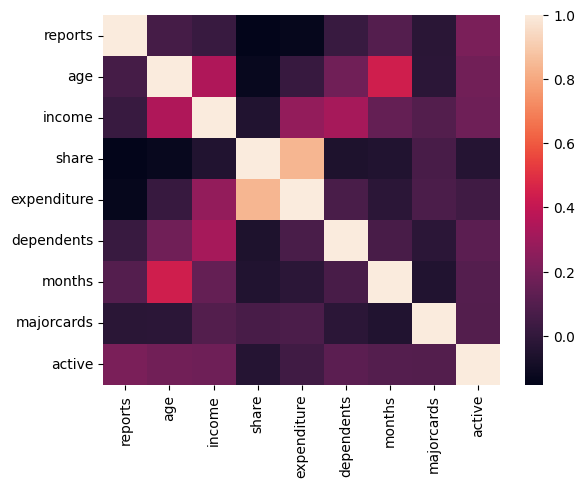

In [40]:
# print Pearson Correlation heatmap
sns.heatmap(EDA_df.corr(numeric_only = True))

The heatmap above shows the correlation between the numerical features, which from it can be concluded that the closely related features are just between `expenditure` and `share`.

Later in the Feature Engineering chapter, I will convert the `income` feature into a monthly value and multiply by 10,000 to get the real value to conform it with the features `expenditure` and `share`.

### Categorical Columns

#### owner vs card

In [41]:
CrosstabCount = pd.crosstab(index=EDA_df['owner'],\
                            columns=EDA_df['card'],\
                            margins = True, margins_name = "total")
print(f"Cross-tabulation of owner and card (count):\n \n{CrosstabCount}")
print("-------------------------------------\n")

CrosstabPerc = pd.crosstab(index=EDA_df['owner'],\
                           columns=EDA_df['card'],\
                           margins = True, margins_name = "total",\
                           normalize = True)*100
print(f"Cross-tabulation of owner and card (percentage):\n \n{CrosstabPerc}")
print("-------------------------------------\n")

CrosstabPerc = pd.crosstab(index=EDA_df['owner'],\
                           columns=EDA_df['card'],\
                           normalize = 'index')*100
print(f"Cross-tabulation of owner and card (relative percentage of owner):\n \n{CrosstabPerc}")

Cross-tabulation of owner and card (count):
 
card    no  yes  total
owner                 
no     143  362    505
yes     61  342    403
total  204  704    908
-------------------------------------

Cross-tabulation of owner and card (percentage):
 
card          no        yes      total
owner                                 
no     15.748899  39.867841   55.61674
yes     6.718062  37.665198   44.38326
total  22.466960  77.533040  100.00000
-------------------------------------

Cross-tabulation of owner and card (relative percentage of owner):
 
card          no        yes
owner                      
no     28.316832  71.683168
yes    15.136476  84.863524


The applicants whose not own a home are the majority, however the homeowners still have a higher probability to be approved.

#### selfemp vs card

In [42]:
CrosstabCount = pd.crosstab(index=EDA_df['selfemp'],\
                            columns=EDA_df['card'],\
                            margins = True, margins_name = "total")
print(f"Cross-tabulation of selfemp and card (count):\n \n{CrosstabCount}")
print("-------------------------------------\n")

CrosstabPerc = pd.crosstab(index=EDA_df['selfemp'],\
                           columns=EDA_df['card'],\
                           margins = True, margins_name = "total",\
                           normalize = True)*100
print(f"Cross-tabulation of selfemp and card (percentage):\n \n{CrosstabPerc}")
print("-------------------------------------\n")

CrosstabPerc = pd.crosstab(index=EDA_df['selfemp'],\
                           columns=EDA_df['card'],\
                           normalize = 'index')*100
print(f"Cross-tabulation of selfemp and card (relative percentage of selfemp):\n \n{CrosstabPerc}")

Cross-tabulation of selfemp and card (count):
 
card      no  yes  total
selfemp                 
no       185  667    852
yes       19   37     56
total    204  704    908
-------------------------------------

Cross-tabulation of selfemp and card (percentage):
 
card            no       yes       total
selfemp                                 
no       20.374449  73.45815   93.832599
yes       2.092511   4.07489    6.167401
total    22.466960  77.53304  100.000000
-------------------------------------

Cross-tabulation of selfemp and card (relative percentage of selfemp):
 
card            no        yes
selfemp                      
no       21.713615  78.286385
yes      33.928571  66.071429


The self-employed applicants are the significant minority, and their probability to be approved is not pretty high, this feature has a low correlation to the credit card approval decision.

## Conclusion



After the thorough data comprehension, I summarize some further works to be done in the next step (data preprocessing and feature engineering), which are:

+ Deletion of the `age` feature valued at less than 18.
+ Data transformation (log-transformation) on `income`, `expenditure`, and `months`.
+ Label Encoding on the categorical features.
+ Data binning on the feature `age`.
+ Conversion of the `income` data to the original value (multiply by 10,000) and divide it to a monthly value (divide by 12).
+ Category Balancing on the feature `card`.







# Data Preprocessing



Prepare the datasets.

In [43]:
# Rename the train dataset
df_train = EDA_df
joblib.dump(df_train, pkl_folder + "df_train.pkl")

# Concatenate the x_valid and y_valid for preprocessing
df_valid = pd.concat([x_valid, y_valid], axis=1).reset_index(drop=True)
joblib.dump(df_valid, pkl_folder + "df_valid.pkl")

# Concatenate the x_test and y_test for preprocessing
df_test = pd.concat([x_test, y_test], axis=1).reset_index(drop=True)
joblib.dump(df_valid, pkl_folder + "df_test.pkl")

['/root/ml_process_feb23/data/processed/df_test.pkl']

## Checking Null Values

In [44]:
string = ["Training Data", "Validation Data", "Testing Data"]
datasets = [df_train, df_valid, df_test]

for x, y in enumerate(string):
    print(f"Null values' count in {y} is: {datasets[x].isna().sum().sum()}")

Null values' count in Training Data is: 0
Null values' count in Validation Data is: 0
Null values' count in Testing Data is: 0


There is no null value in these datasets, so let's progress to the next data preprocessing process.

## Data Deletion

The data in feature `age` valued at less than 18 will be dropped.

### Training Data

In [45]:
# Update the dataset, only include the value more than and equal to 18
df_train = df_train.loc[df_train['age'] >= 18].reset_index()
joblib.dump(df_train, pkl_folder + "df_train.pkl")

['/root/ml_process_feb23/data/processed/df_train.pkl']

### Validation Data

In [46]:
# Update the dataset, only include the value more than and equal to 18
df_valid = df_valid.loc[df_valid['age'] >= 18].reset_index()
joblib.dump(df_valid, pkl_folder + "df_valid.pkl")

['/root/ml_process_feb23/data/processed/df_valid.pkl']

### Testing Data

In [47]:
# Update the dataset, only include the value more than and equal to 18
df_test = df_test.loc[df_test['age'] >= 18].reset_index()
joblib.dump(df_test, pkl_folder + "df_test.pkl")

['/root/ml_process_feb23/data/processed/df_test.pkl']

## Data Transformation

For the data with an extensive range, I will transform them to squeeze the range so the distribution will get near to a normal distribution than a skewed one.

The features that need to be transformed are: `income`, `expenditure`, and `months`.

In [48]:
# Group the features to be transformed
cols_to_logtransf = ['income', 'expenditure', 'months']

### Training Data

The histogram plots before transformation


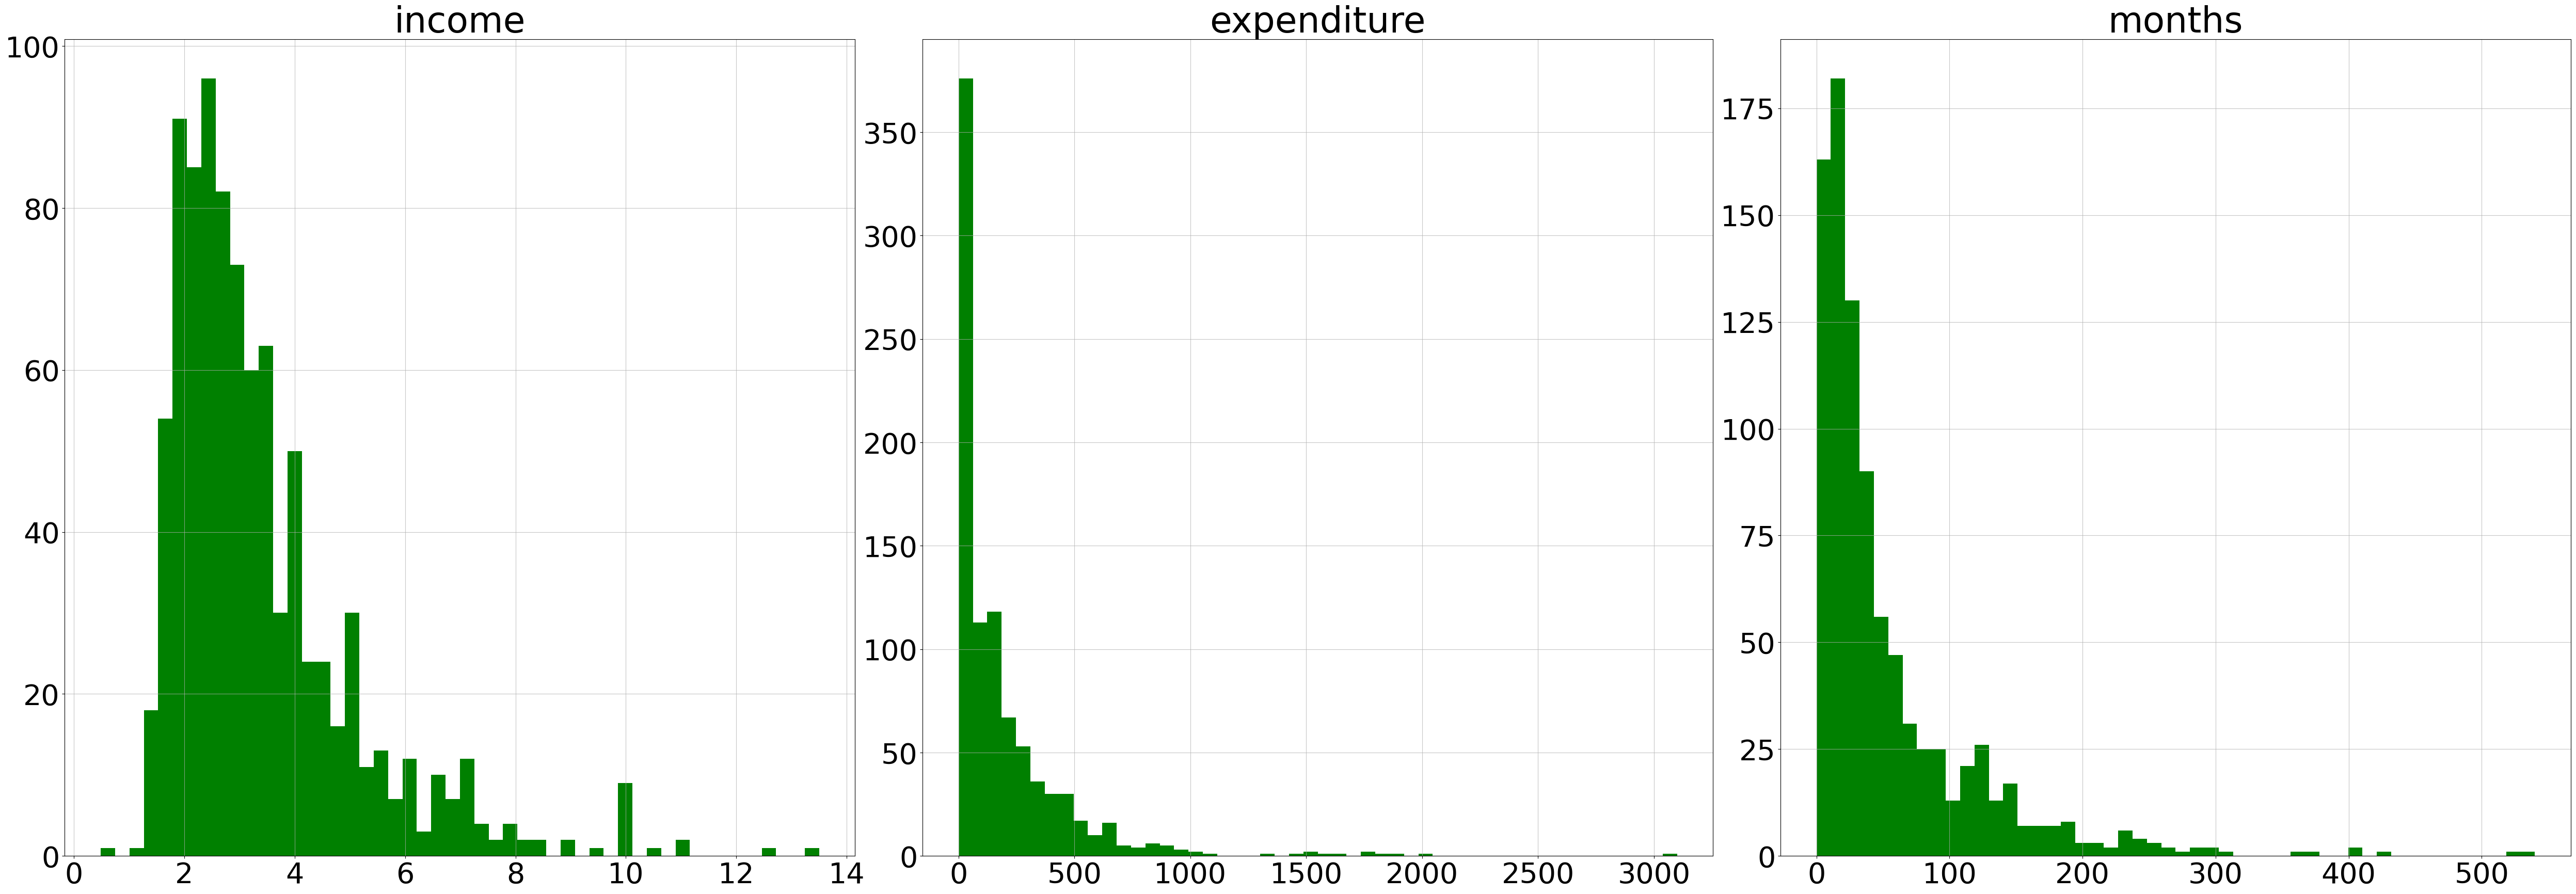

In [49]:
print("The histogram plots before transformation")
draw_histograms(df_train, cols_to_logtransf, 3, 3, 50)

In [50]:
# Create function to transform
log_cols = []
for i in range (len(cols_to_logtransf)):
    col = cols_to_logtransf[i]
    transformed = col + "_log" 
    df_train[transformed] = np.log10(df_train[col]+1)
    
    log_cols.append(transformed)

The histogram plots of the transformed features


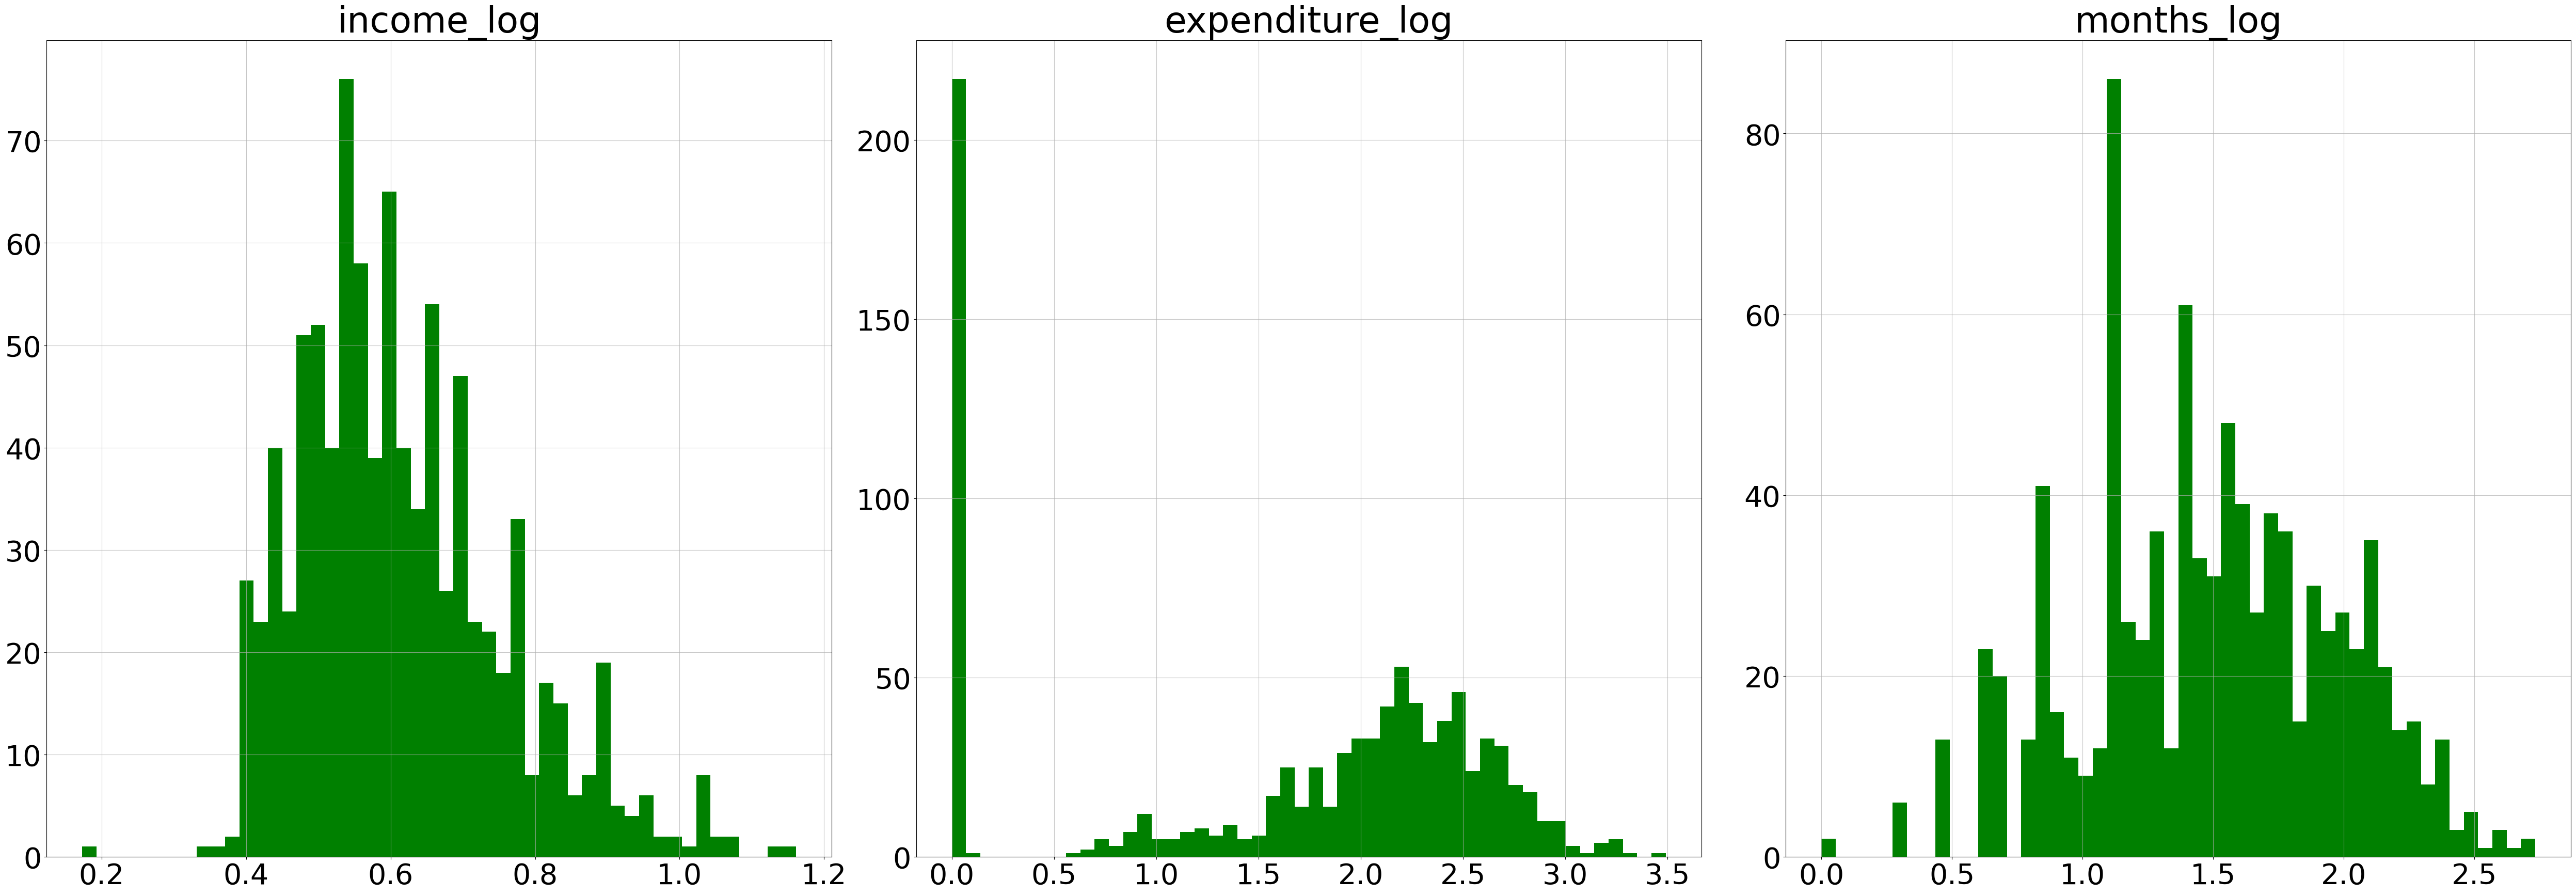

In [51]:
print("The histogram plots of the transformed features")
draw_histograms(df_train, log_cols, 3, 3, 50)

In [52]:
# Updating the dataset by dropping the `income`, `expenditure`, and `months` features
df_train.drop(cols_to_logtransf, axis = 1, inplace = True)
joblib.dump(df_train, pkl_folder + "df_train.pkl")

['/root/ml_process_feb23/data/processed/df_train.pkl']

### Validation Data

The histogram plots before transformation


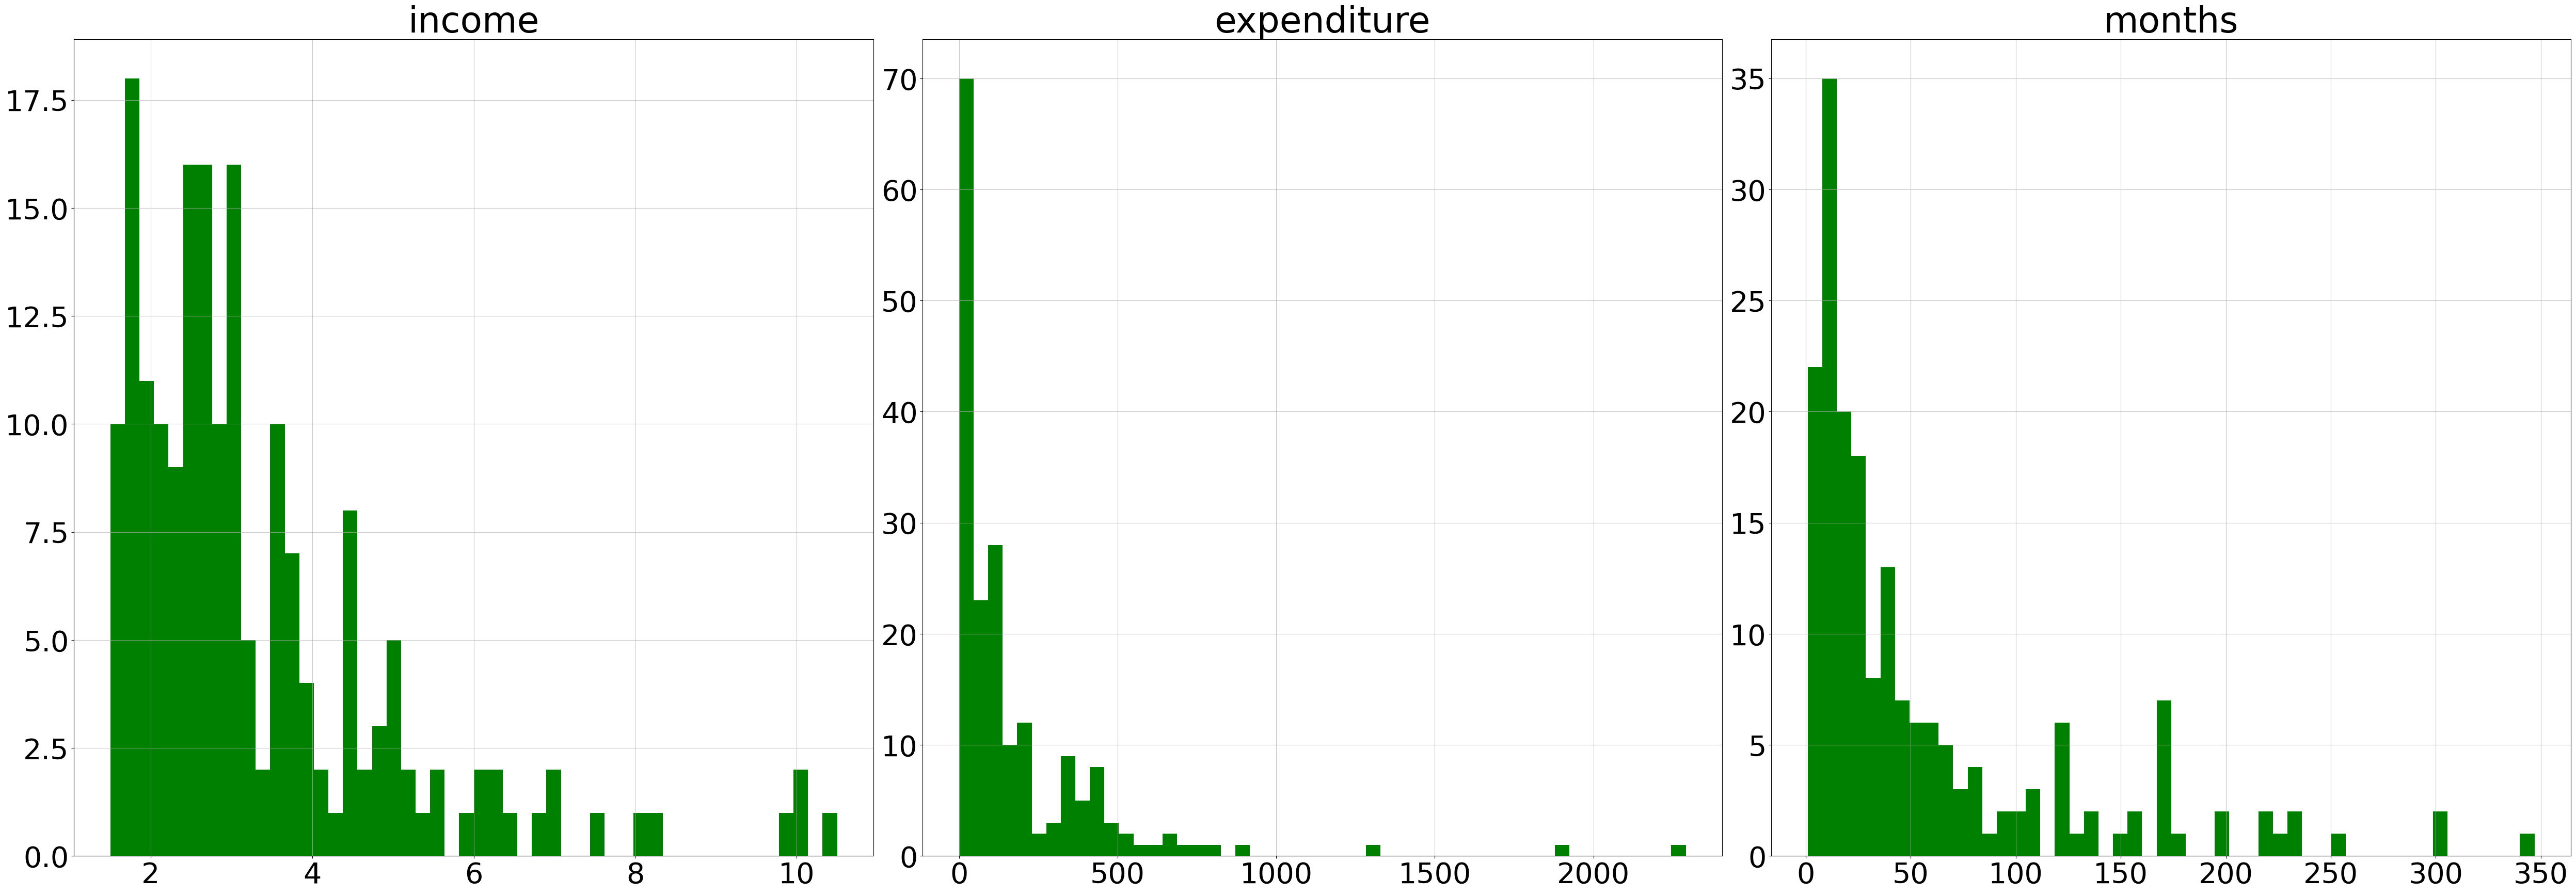

In [53]:
print("The histogram plots before transformation")
draw_histograms(df_valid, cols_to_logtransf, 3, 3, 50)

In [54]:
log_cols = []
for i in range (len(cols_to_logtransf)):
    col = cols_to_logtransf[i]
    transformed = col + "_log"
    df_valid[transformed] = np.log10(df_valid[col]+1)
    
    log_cols.append(transformed)

The histogram plots of the transformed features


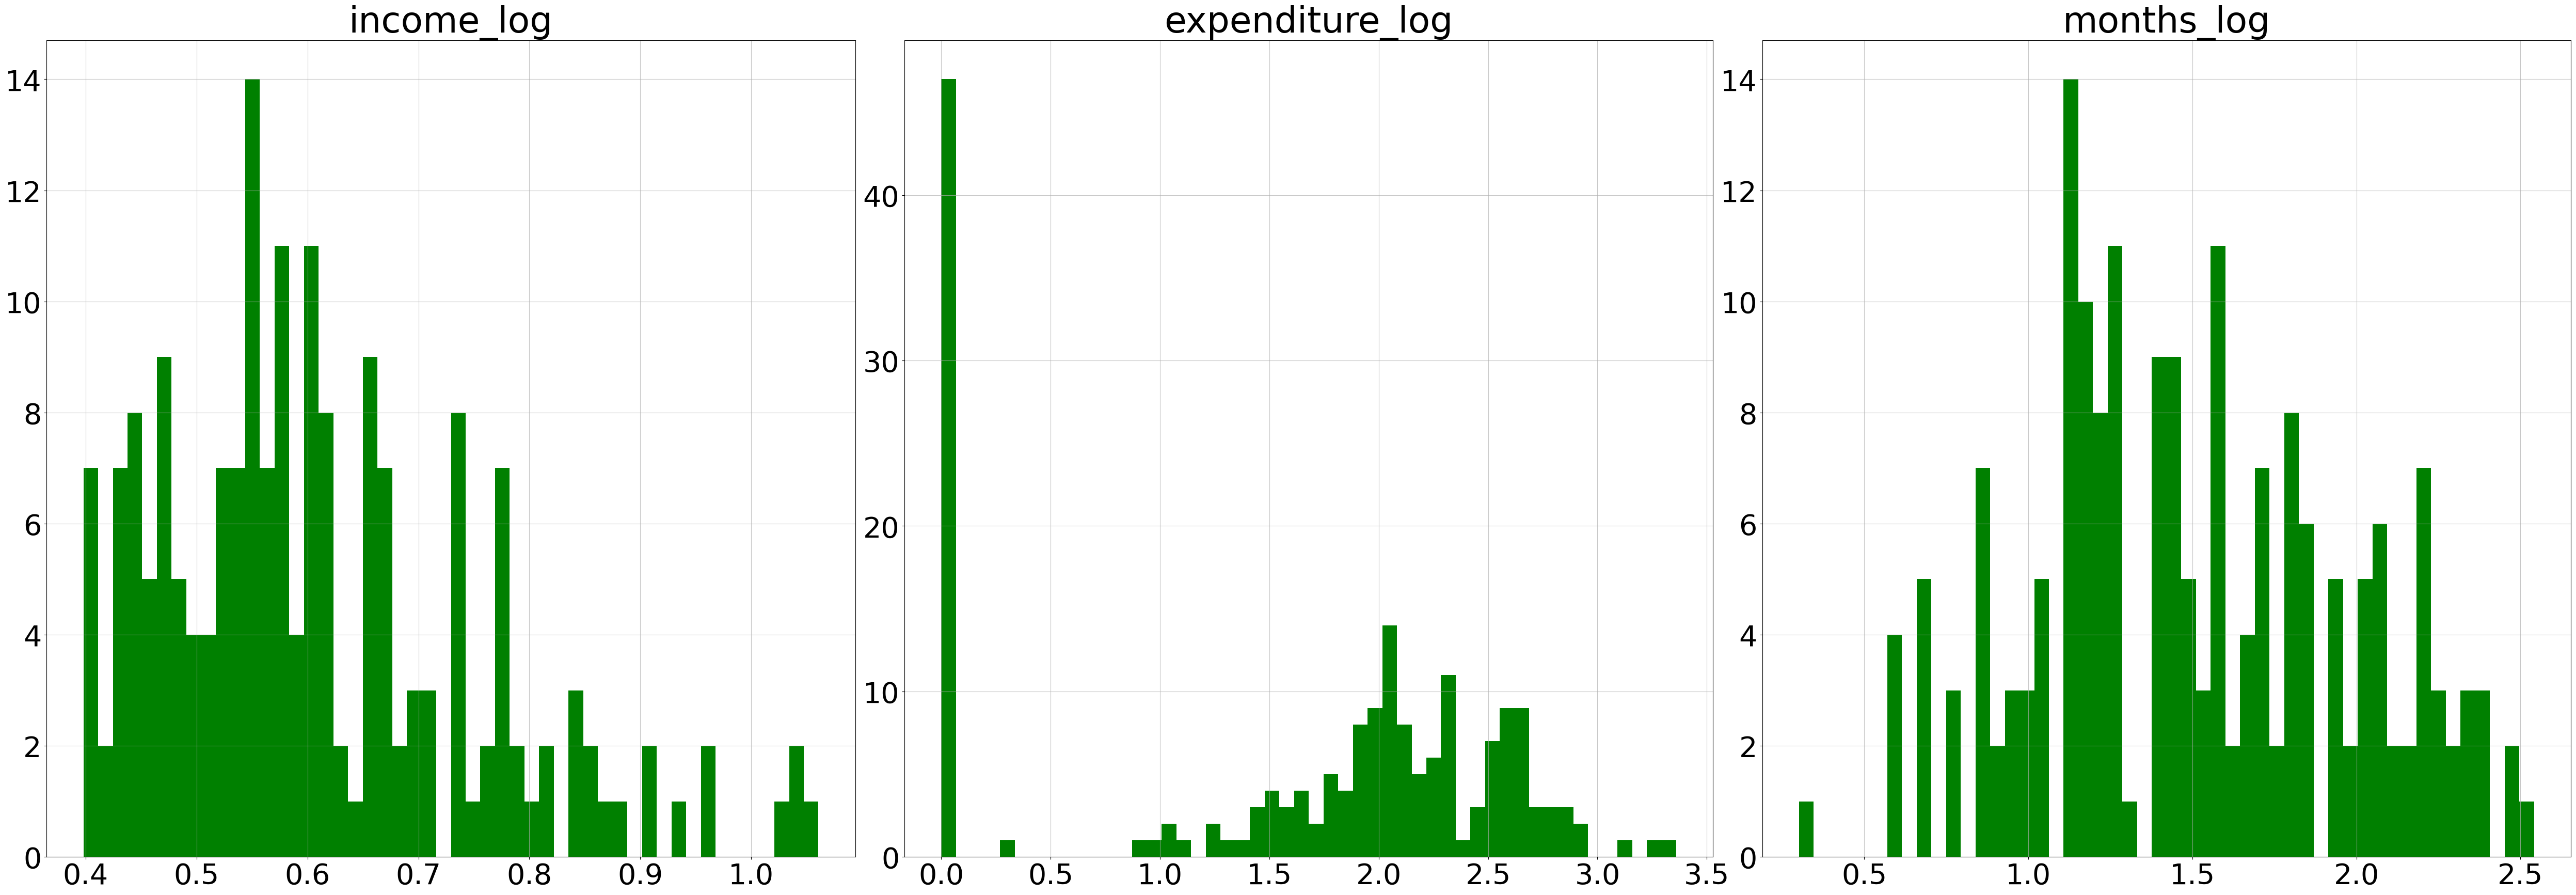

In [55]:
print("The histogram plots of the transformed features")
draw_histograms(df_valid, log_cols, 3, 3, 50)

In [56]:
# Updating the dataset by dropping the `income`, `expenditure`, and `months` features
df_valid.drop(cols_to_logtransf, axis = 1, inplace = True)
joblib.dump(df_valid, pkl_folder + "df_valid.pkl")

['/root/ml_process_feb23/data/processed/df_valid.pkl']

### Testing Data

The histogram plots before transformation


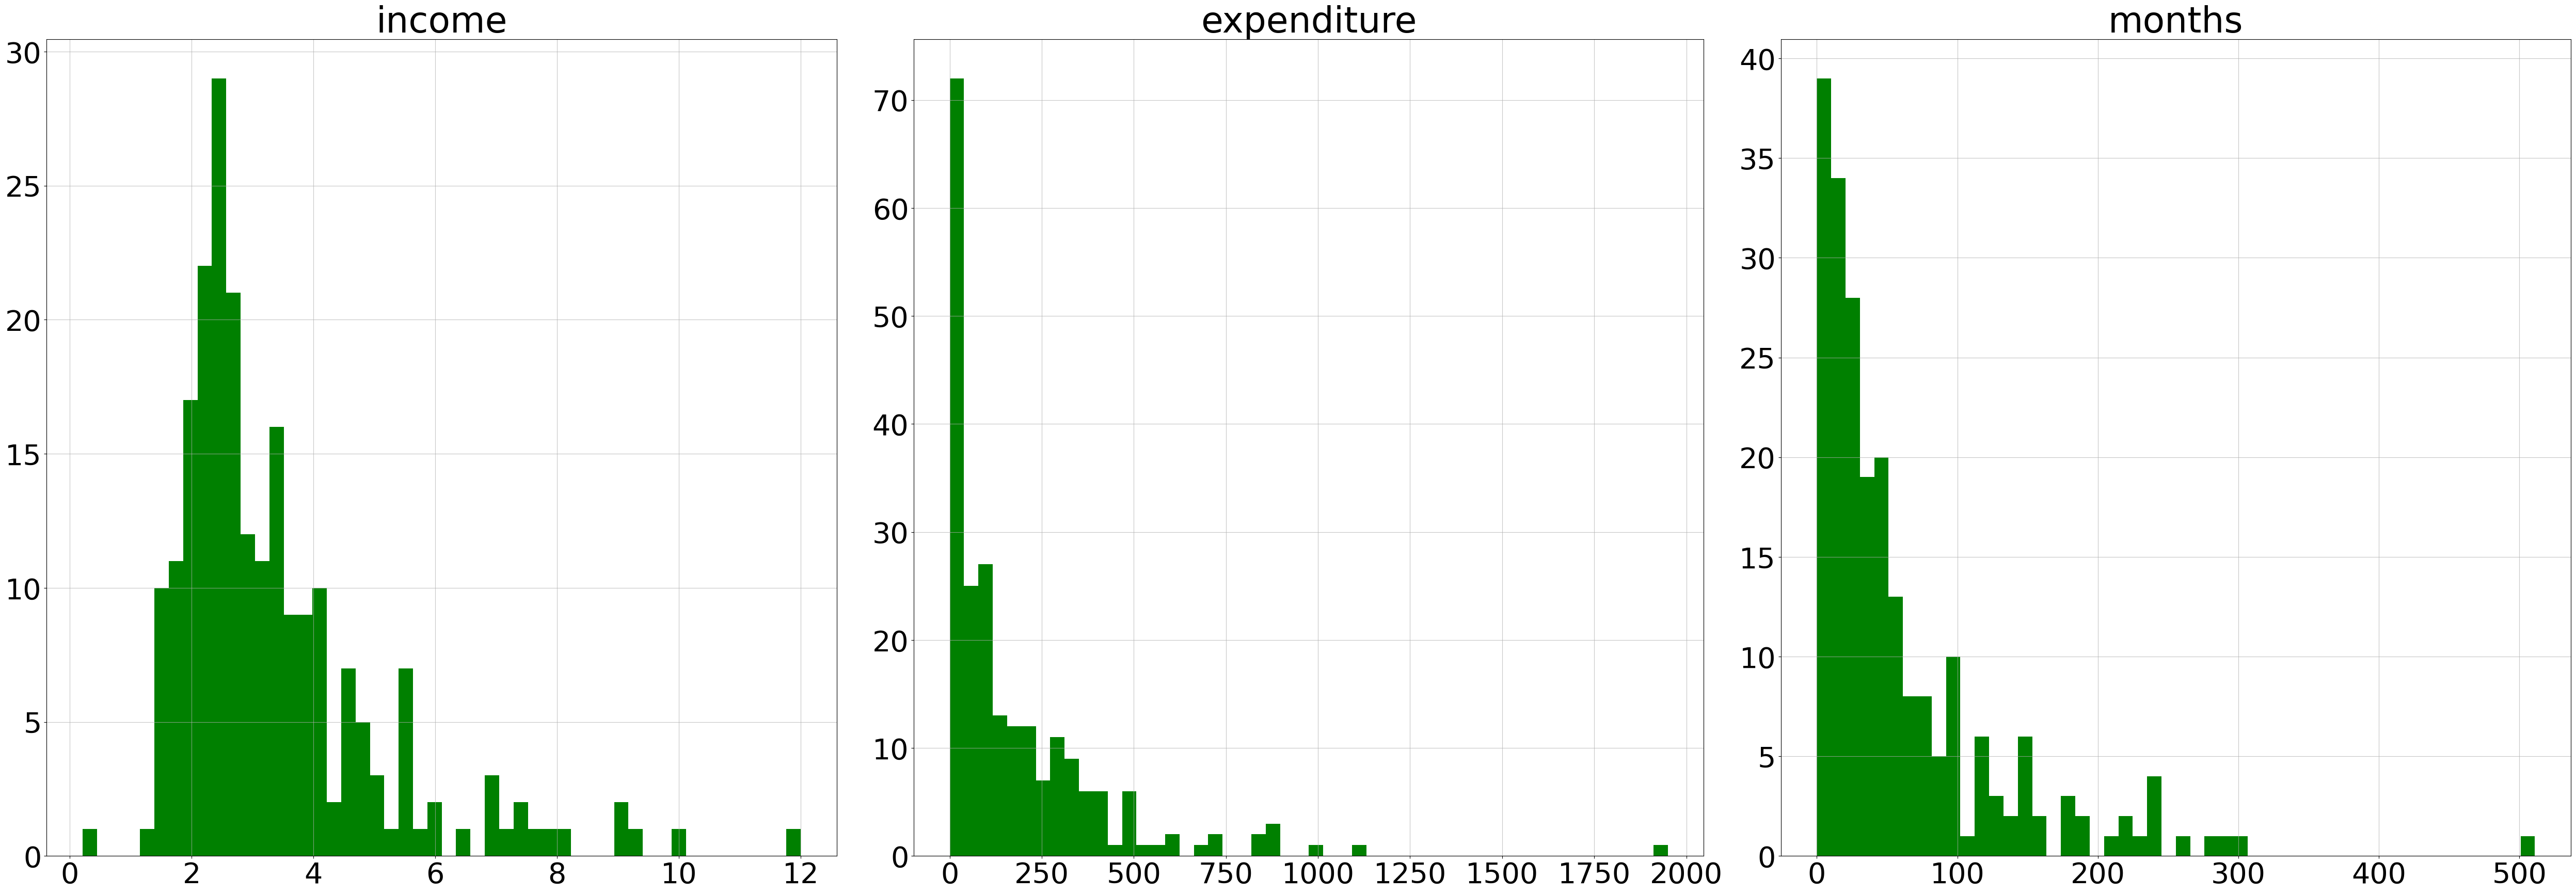

In [57]:
print("The histogram plots before transformation")
draw_histograms(df_test, cols_to_logtransf, 3, 3, 50)

In [58]:
log_cols = []
for i in range (len(cols_to_logtransf)):
    col = cols_to_logtransf[i]
    transformed = col + "_log" 
    df_test[transformed] = np.log10(df_test[col]+1)
    
    log_cols.append(transformed)

The histogram plots of the transformed features


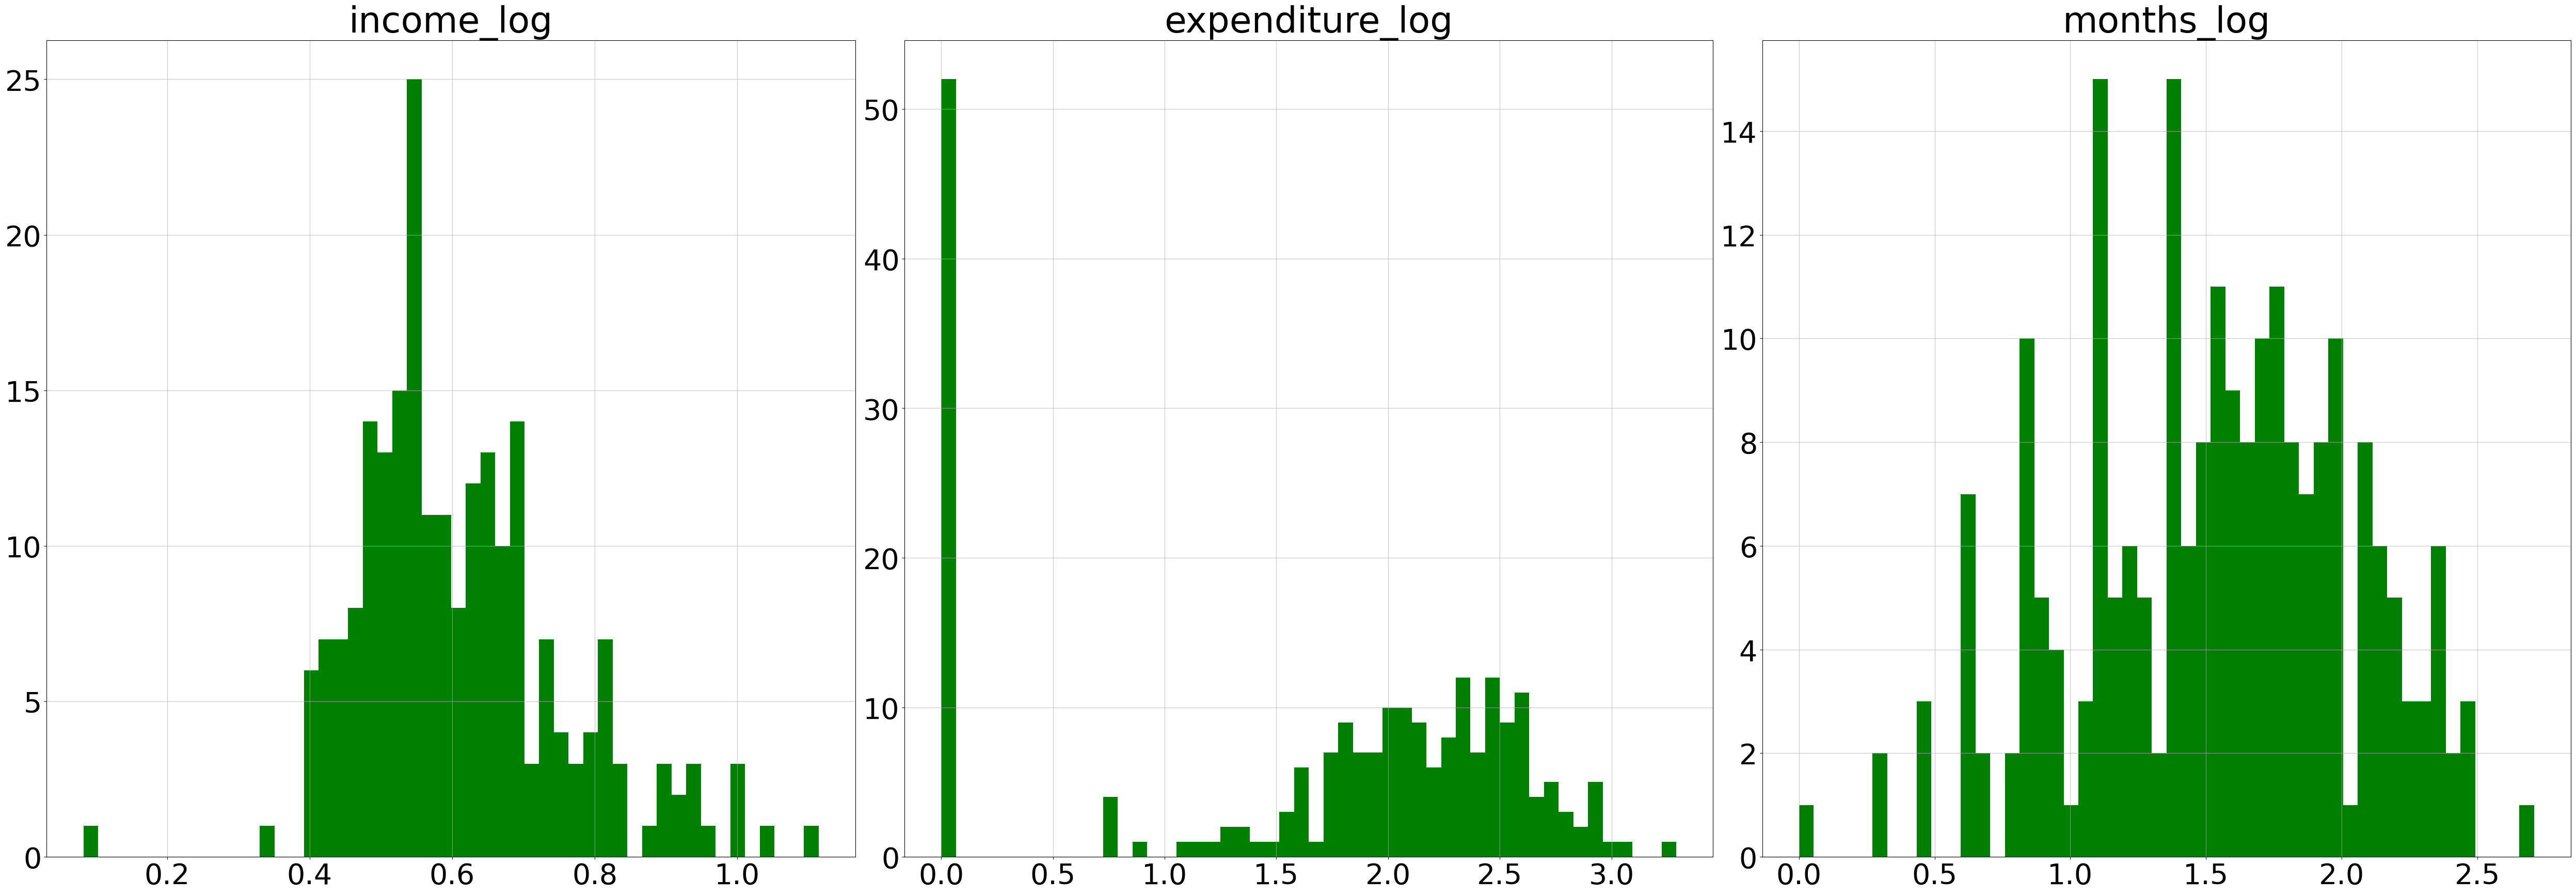

In [59]:
print("The histogram plots of the transformed features")
draw_histograms(df_test, log_cols, 3, 3, 50)

In [60]:
# Updating the dataset by dropping the `income`, `expenditure`, and `months` features
df_test.drop(cols_to_logtransf, axis = 1, inplace = True)
joblib.dump(df_test, pkl_folder + "df_test.pkl")

['/root/ml_process_feb23/data/processed/df_test.pkl']

## Label Encoding

Convert the values of categorical features into numeric ones.

The features are: `owner`, `selfemp`, and `card`.

The encoded result value are 0 (zero) for "no", and 1 for "yes".

Let's first check the columns:

In [61]:
print(f"The Original Categorical Columns:\n{df_train[categorical_columns].tail()}\n")

df_train[categorical_columns].info()


The Original Categorical Columns:
    owner selfemp card
899    no      no  yes
900   yes      no   no
901    no      no  yes
902   yes      no  yes
903    no      no   no

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   owner    904 non-null    object
 1   selfemp  904 non-null    object
 2   card     904 non-null    object
dtypes: object(3)
memory usage: 21.3+ KB


### Training Data

In [62]:
# Create function to encode the categorical columns
for i in range (len(categorical_columns)):
    col = categorical_columns[i]
    df_train[col] = df_train[col].map({'yes':1, 'no':0})

In [63]:
print(f"The Encoded Categorical Columns:\n{df_train[categorical_columns].tail()}\n")

df_train[categorical_columns].info()

The Encoded Categorical Columns:
     owner  selfemp  card
899      0        0     1
900      1        0     0
901      0        0     1
902      1        0     1
903      0        0     0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   owner    904 non-null    int64
 1   selfemp  904 non-null    int64
 2   card     904 non-null    int64
dtypes: int64(3)
memory usage: 21.3 KB


In [64]:
# Save the updated dataset
joblib.dump(df_train, pkl_folder + "df_train.pkl")

['/root/ml_process_feb23/data/processed/df_train.pkl']

### Validation Data

In [65]:
# Create function to encode the categorical columns
for i in range (len(categorical_columns)):
    col = categorical_columns[i]
    df_valid[col] = df_valid[col].map({'yes':1, 'no':0})

In [66]:
print(f"The Encoded Categorical Columns:\n{df_valid[categorical_columns].tail()}\n")

df_valid[categorical_columns].info()

The Encoded Categorical Columns:
     owner  selfemp  card
181      0        0     1
182      0        0     1
183      1        0     1
184      1        0     0
185      1        0     1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   owner    186 non-null    int64
 1   selfemp  186 non-null    int64
 2   card     186 non-null    int64
dtypes: int64(3)
memory usage: 4.5 KB


In [67]:
# Save the updated dataset
joblib.dump(df_valid, pkl_folder + "df_valid.pkl")

['/root/ml_process_feb23/data/processed/df_valid.pkl']

### Testing Data

In [68]:
# Create function to encode the categorical columns
for i in range (len(categorical_columns)):
    col = categorical_columns[i]
    df_test[col] = df_test[col].map({'yes':1, 'no':0})

In [69]:
print(f"The Encoded Categorical Columns:\n{df_test[categorical_columns].tail()}\n")

df_test[categorical_columns].info()

The Encoded Categorical Columns:
     owner  selfemp  card
217      1        0     1
218      1        0     1
219      0        0     1
220      1        0     0
221      0        0     1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   owner    222 non-null    int64
 1   selfemp  222 non-null    int64
 2   card     222 non-null    int64
dtypes: int64(3)
memory usage: 5.3 KB


In [70]:
# Save the updated dataset
joblib.dump(df_test, pkl_folder + "df_test.pkl")

['/root/ml_process_feb23/data/processed/df_test.pkl']

## Data Binning

The data binning process is useful to smoothen the data, it replaces values contained into a small interval with a single representative value for that interval, in order to improves the model accuracy.

The features that suitable to be binned are: `age`, `reports`, `dependents`, and `active`.



### `age`

The age groups are divide based on the classification from FICO, source: [Age group for credit scoring](https://www.americanexpress.com/en-us/credit-cards/credit-intel/credit-score-by-age-state/)

The category definition of this feature are:
+ 1: 18 - 24 years old
+ 2: 25 - 40 years old
+ 3: 41 - 56 years old
+ 4: 57 - 75 years old
+ 5: more than 75 years old 

In [71]:
# Create the instance for the value boundary for each category
bins = [18, 24, 40, 56, 75, 99]

# Create the instance for age category labels
labels = [1, 2, 3, 4, 5]

#### Training Data

count    904.000000
mean      33.376475
std       10.025190
min       18.166670
25%       25.395835
50%       31.333330
75%       39.020832
max       83.500000
Name: age, dtype: float64
Median: 31.33333


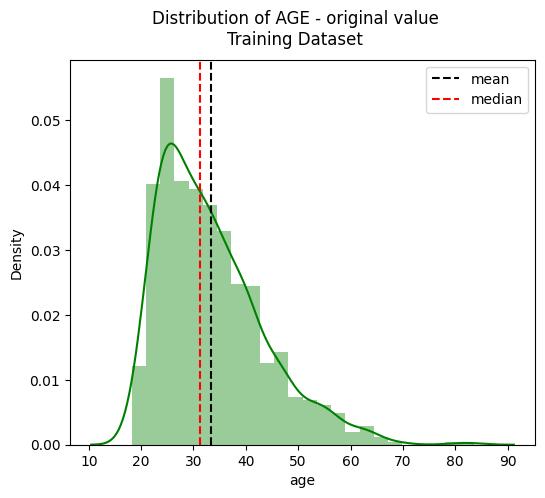

In [72]:
# Print the statistical information and histogram plot before data binning
x = df_train['age']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - original value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [73]:
# Divide the `age` feature into the categories
df_train['age_bin'] = pd.cut(df_train['age'] , bins=bins, labels=labels, include_lowest=True).astype(int)

# Check the binning result and compare it with the original `age` value
df_train[['age', 'age_bin']].tail(10)

,age,age_bin
894,31.16667,2
895,21.25000,1
896,36.25000,2
897,26.66667,2
898,32.16667,2
899,29.83333,2
900,41.33333,3
901,45.00000,3
902,23.50000,1
903,27.08333,2


count    904.000000
mean       2.088496
std        0.701936
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: age_bin, dtype: float64
Median: 2.0


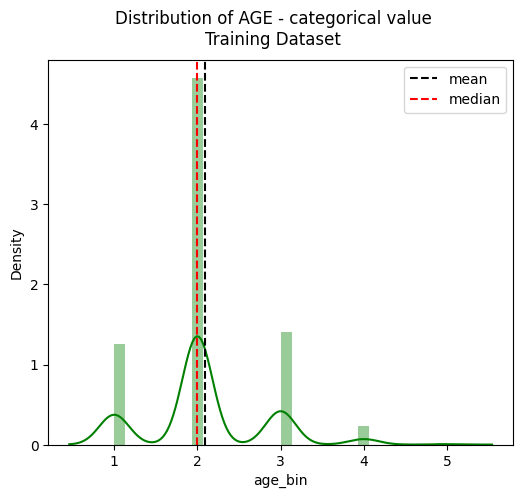

In [74]:
# Print the statistical information and histogram plot after data binning
x = df_train['age_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - categorical value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [75]:
# Save the updated dataset
joblib.dump(df_train, pkl_folder + "df_train.pkl")

['/root/ml_process_feb23/data/processed/df_train.pkl']

#### Validation Data

count    186.000000
mean      33.016577
std        8.817374
min       18.666670
25%       25.729170
50%       31.666665
75%       39.687500
max       60.250000
Name: age, dtype: float64
Median: 31.666665000000002


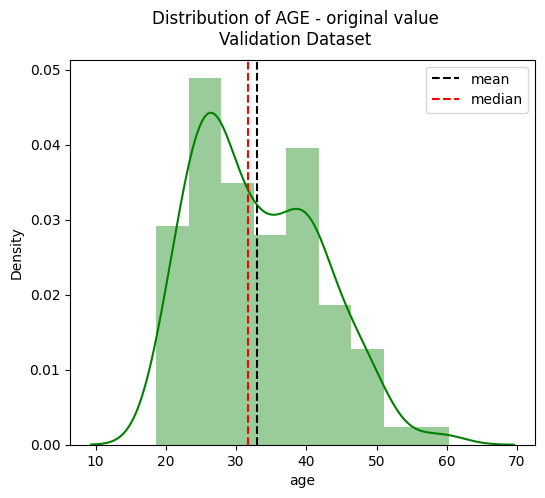

In [76]:
# Print the statistical information and histogram plot before data binning
  
x = df_valid['age']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - original value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [77]:
# Divide the `age` feature into the categories
df_valid['age_bin'] = pd.cut(df_valid['age'] , bins=bins, labels=labels, include_lowest=True).astype(int)

# Check the binning result and compare it with the original `age` value
df_valid[['age', 'age_bin']].tail(10)

,age,age_bin
176,20.66667,1
177,33.58333,2
178,38.08333,2
179,27.08333,2
180,52.16667,3
181,33.25000,2
182,19.66667,1
183,32.58333,2
184,35.83333,2
185,33.75000,2


count    186.000000
mean       2.096774
std        0.650397
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: age_bin, dtype: float64
Median: 2.0


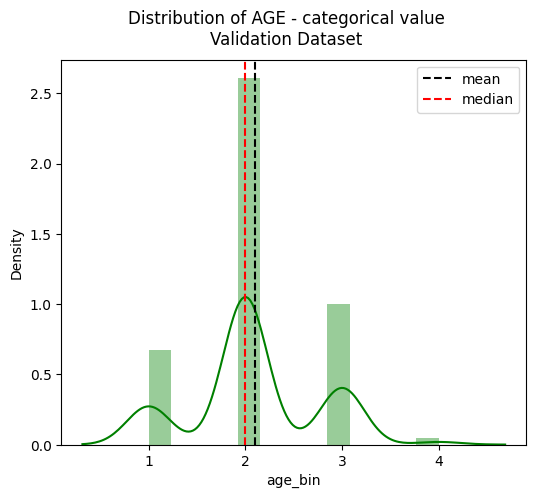

In [78]:
# Print the statistical information and histogram plot after data binning
x = df_valid['age_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - categorical value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [79]:
# Save the updated dataset
joblib.dump(df_valid, pkl_folder + "df_valid.pkl")

['/root/ml_process_feb23/data/processed/df_valid.pkl']

#### Testing Data

count    222.000000
mean      33.742492
std       10.176963
min       19.583330
25%       25.458335
50%       30.583330
75%       40.354170
max       74.166660
Name: age, dtype: float64
Median: 30.58333


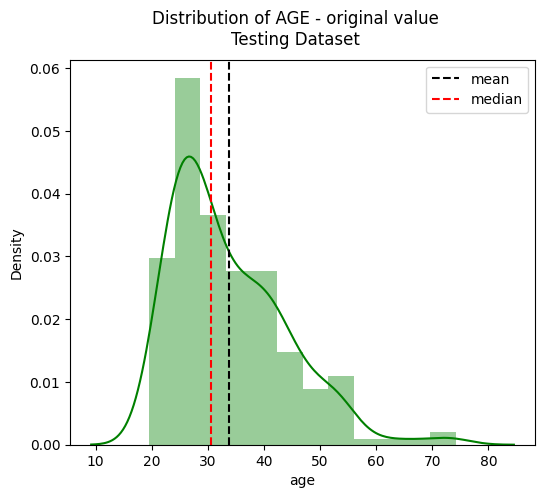

In [80]:
# Print the statistical information and histogram plot before data binning
  
x = df_test['age']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - original value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [81]:
# Divide the `age` feature into the categories
df_test['age_bin'] = pd.cut(df_test['age'] , bins=bins, labels=labels, include_lowest=True).astype(int)

# Check the binning result and compare it with the original `age` value
df_test[['age', 'age_bin']].tail(10)

,age,age_bin
212,27.75000,2
213,40.75000,3
214,30.25000,2
215,24.16667,2
216,28.58333,2
217,21.00000,1
218,30.41667,2
219,29.00000,2
220,35.58333,2
221,28.91667,2


count    222.000000
mean       2.153153
std        0.661798
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: age_bin, dtype: float64
Median: 2.0


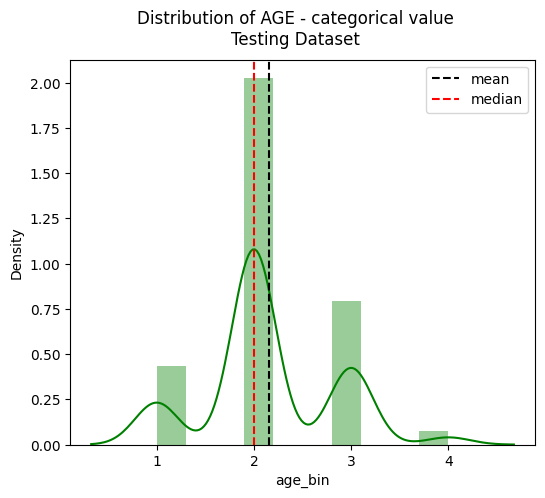

In [82]:
# Print the statistical information and histogram plot after data binning
x = df_test['age_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of AGE - categorical value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [83]:
# Save the updated dataset
joblib.dump(df_test, pkl_folder + "df_test.pkl")

['/root/ml_process_feb23/data/processed/df_test.pkl']

### `reports`

The category definition of this feature are:
+ 0: zero major derogatory report, "clean record"
+ 1: 1 - 2 major derogatory reports
+ 2: 3 or more major derogatory report, "bad record"

In [84]:
# Create the instance for the value boundary for each category
bins = [0, 0.99, 2, 14]

# Create the instance for `reports` category labels
labels = [0, 1, 2]

#### Training Data

count    904.000000
mean       0.418142
std        1.251330
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       12.000000
Name: reports, dtype: float64
Median: 0.0


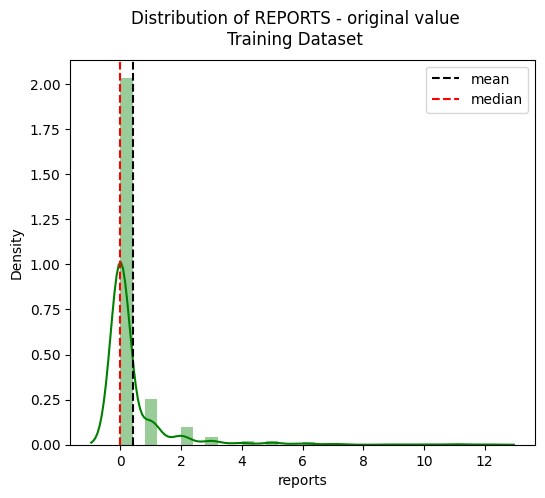

In [85]:
# Print the statistical information and histogram plot before data binning
x = df_train['reports']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - original value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [86]:
# Divide the `reports` feature into the categories
df_train['reports_bin'] = pd.cut(df_train['reports'] , bins=bins, labels=labels, include_lowest=True).astype(int)

# Check the binning result and compare it with the original `reports` value
df_train[['reports', 'reports_bin']].tail(10)

,reports,reports_bin
894,0,0
895,0,0
896,0,0
897,0,0
898,3,2
899,0,0
900,0,0
901,0,0
902,0,0
903,0,0


count    904.000000
mean       0.234513
std        0.524360
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: reports_bin, dtype: float64
Median: 0.0


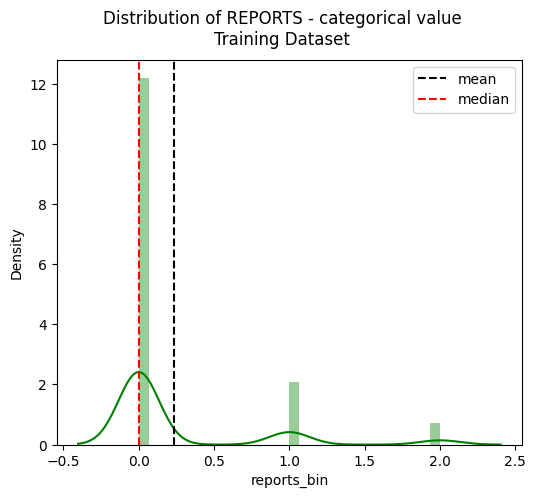

In [87]:
# Print the statistical information and histogram plot after data binning
x = df_train['reports_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [88]:
# Save the updated dataset
joblib.dump(df_train, pkl_folder + "df_train.pkl")

['/root/ml_process_feb23/data/processed/df_train.pkl']

#### Validation Data

count    186.00000
mean       0.44086
std        1.39855
min        0.00000
25%        0.00000
50%        0.00000
75%        0.00000
max       14.00000
Name: reports, dtype: float64
Median: 0.0


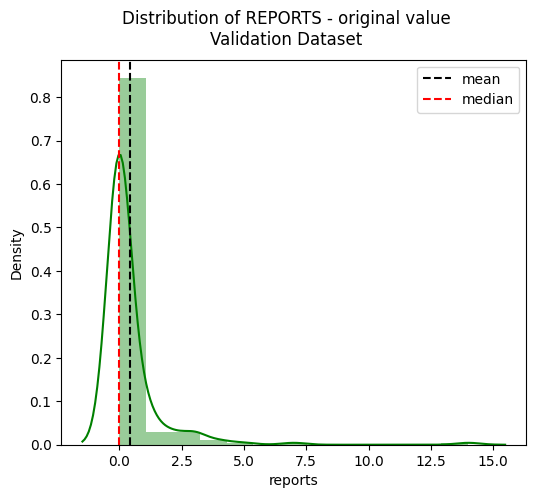

In [89]:
# Print the statistical information and histogram plot before data binning
x = df_valid['reports']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - original value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [90]:
# Divide the `reports` feature into the categories
df_valid['reports_bin'] = pd.cut(df_valid['reports'] , bins=bins, labels=labels, include_lowest=True).astype(int)

# Check the binning result and compare it with the original `reports` value
df_valid[['reports', 'reports_bin']].tail(10)

,reports,reports_bin
176,0,0
177,0,0
178,0,0
179,0,0
180,0,0
181,0,0
182,0,0
183,0,0
184,0,0
185,0,0


count    186.000000
mean       0.247312
std        0.553239
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: reports_bin, dtype: float64
Median: 0.0


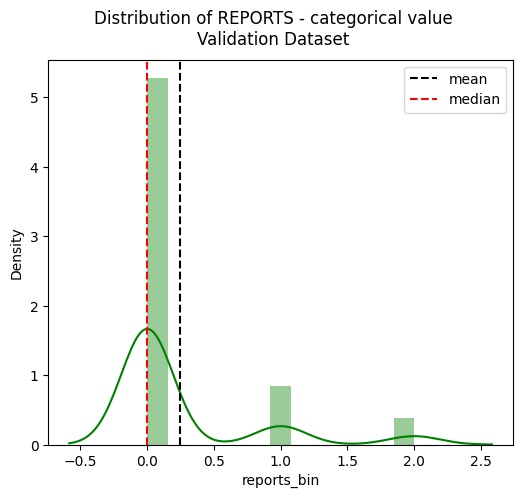

In [91]:
# Print the statistical information and histogram plot after data binning
x = df_valid['reports_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [92]:
# Save the updated dataset
joblib.dump(df_valid, pkl_folder + "df_valid.pkl")

['/root/ml_process_feb23/data/processed/df_valid.pkl']

#### Testing Data

count    222.000000
mean       0.635135
std        1.646944
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       11.000000
Name: reports, dtype: float64
Median: 0.0


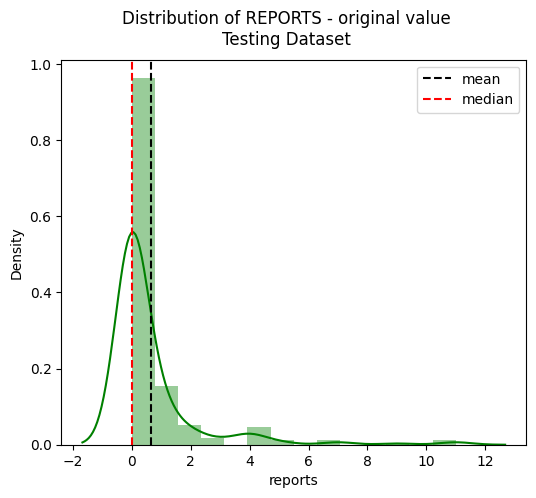

In [93]:
# Print the statistical information and histogram plot before data binning
x = df_test['reports']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - original value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [94]:
# Divide the `reports` feature into the categories
df_test['reports_bin'] = pd.cut(df_test['reports'] , bins=bins, labels=labels, include_lowest=True).astype(int)

# Check the binning result and compare it with the original `reports` value
df_test[['reports', 'reports_bin']].tail(10)

,reports,reports_bin
212,0,0
213,0,0
214,0,0
215,0,0
216,5,2
217,0,0
218,0,0
219,0,0
220,2,1
221,0,0


count    222.000000
mean       0.324324
std        0.618891
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: reports_bin, dtype: float64
Median: 0.0


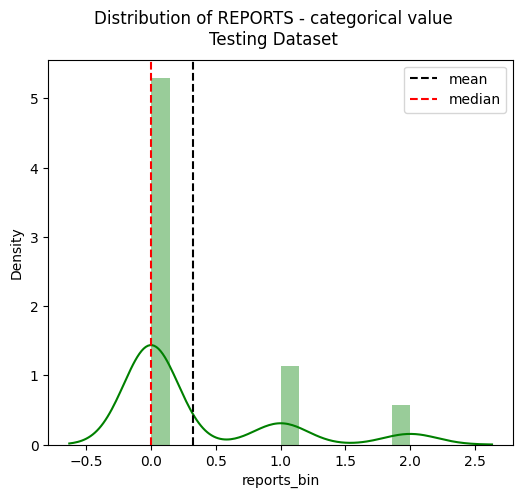

In [95]:
# Print the statistical information and histogram plot after data binning
x = df_test['reports_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [96]:
# Save the updated dataset
joblib.dump(df_test, pkl_folder + "df_test.pkl")

['/root/ml_process_feb23/data/processed/df_test.pkl']

### `dependents`

For this feature, I categorize by the applicant's marital status and the number of children they have.

The category definition of this feature are:
+ 0: marital status is "single"
+ 1: married, without a child
+ 2: married with 1 or 2 children, "small family" 
+ 3: married with 3 or more children, "big family"



In [97]:
# Create the instance for the value boundary for each category
bins = [0, 0.99, 1.99, 3, 6]

# Create the instance for `reports` category labels
labels = [0, 1, 2, 3]

#### Training Data

count    904.000000
mean       0.955752
std        1.225527
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        6.000000
Name: dependents, dtype: float64
Median: 0.0


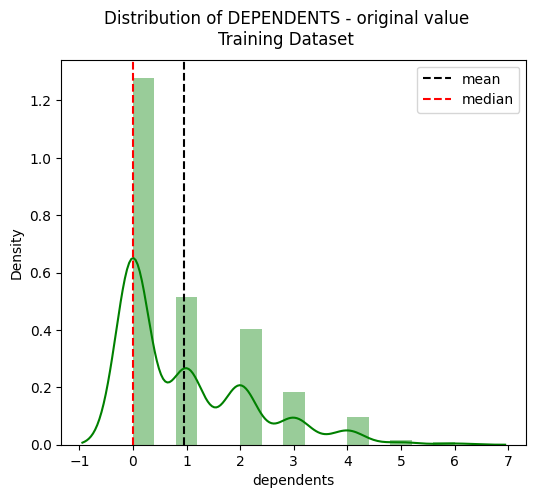

In [98]:
# Print the statistical information and histogram plot before data binning
x = df_train['dependents']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of DEPENDENTS - original value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [99]:
# Divide the `dependents` feature into the categories
df_train['dependents_bin'] = pd.cut(df_train['dependents'] , bins=bins, labels=labels, include_lowest=True).astype(int)

# Check the binning result and compare it with the original `dependents` value
df_train[['dependents', 'dependents_bin']].tail(10)

,dependents,dependents_bin
894,1,1
895,0,0
896,2,2
897,1,1
898,3,2
899,0,0
900,2,2
901,0,0
902,0,0
903,0,0


count    904.000000
mean       0.820796
std        0.953497
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        3.000000
Name: dependents_bin, dtype: float64
Median: 0.0


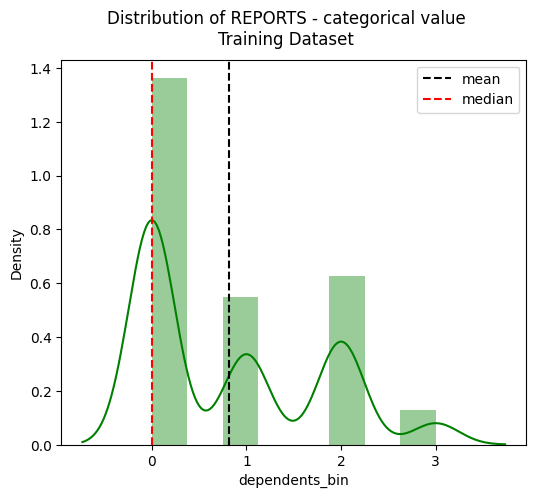

In [100]:
# Print the statistical information and histogram plot after data binning
x = df_train['dependents_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [101]:
# Save the updated dataset
joblib.dump(df_train, pkl_folder + "df_train.pkl")

['/root/ml_process_feb23/data/processed/df_train.pkl']

#### Validation Data

count    186.000000
mean       1.204301
std        1.352149
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        6.000000
Name: dependents, dtype: float64
Median: 1.0


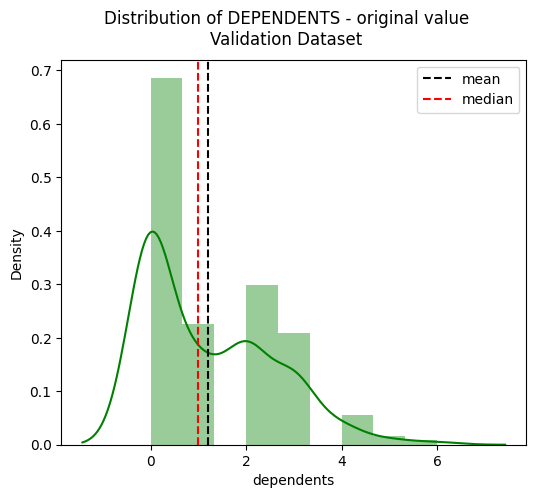

In [102]:
# Print the statistical information and histogram plot before data binning
x = df_valid['dependents']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of DEPENDENTS - original value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())


In [103]:
# Divide the `dependents` feature into the categories
df_valid['dependents_bin'] = pd.cut(df_valid['dependents'] , bins=bins, labels=labels, include_lowest=True).astype(int)

# Check the binning result and compare it with the original `dependents` value
df_valid[['dependents', 'dependents_bin']].tail(10)


,dependents,dependents_bin
176,0,0
177,3,2
178,0,0
179,0,0
180,1,1
181,3,2
182,0,0
183,0,0
184,6,3
185,3,2


count    186.000000
mean       0.989247
std        1.008018
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: dependents_bin, dtype: float64
Median: 1.0


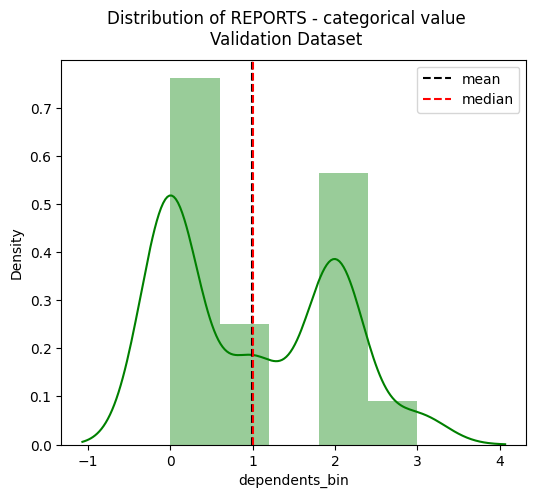

In [104]:
# Print the statistical information and histogram plot after data binning
x = df_valid['dependents_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())


In [105]:
# Save the updated dataset
joblib.dump(df_valid, pkl_folder + "df_valid.pkl")

['/root/ml_process_feb23/data/processed/df_valid.pkl']

#### Testing Data

In [106]:
# Divide the `dependents` feature into the categories
df_test['dependents_bin'] = pd.cut(df_test['dependents'] , bins=bins, labels=labels, include_lowest=True).astype(int)

# Check the binning result and compare it with the original `dependents` value
df_test[['dependents', 'dependents_bin']].tail(10)

,dependents,dependents_bin
212,0,0
213,3,2
214,1,1
215,0,0
216,0,0
217,0,0
218,3,2
219,0,0
220,1,1
221,1,1


count    222.000000
mean       0.819820
std        0.904471
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: dependents_bin, dtype: float64
Median: 1.0


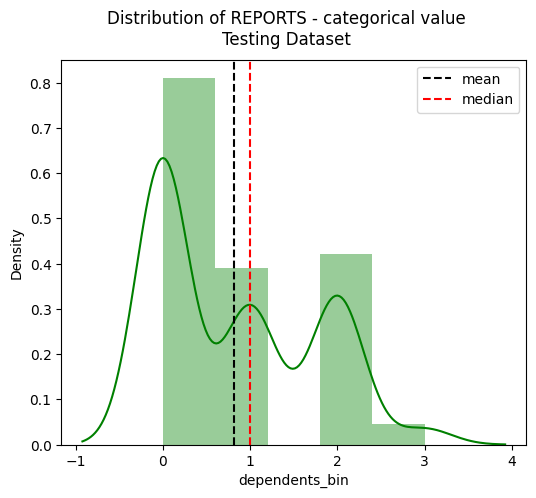

In [107]:
# Print the statistical information and histogram plot after data binning
x = df_test['dependents_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of REPORTS - categorical value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())


In [108]:
# Save the updated dataset
joblib.dump(df_test, pkl_folder + "df_test.pkl")

['/root/ml_process_feb23/data/processed/df_test.pkl']

### `active`

Based on [The New York Fed](https://www.newyorkfed.org/aboutthefed/whatwedo), average Americans have 5 - 6 active credit accounts, the detail can be read [in this link](https://www.newyorkfed.org/medialibrary/interactives/householdcredit/data/pdf/data_dictionary_HHDC.pdf) (page 2, section "Loan types").

The category definition of this feature are:
+ 0: zero active credit account
+ 1: 1 - 4 active credit accounts
+ 2: 5 - 6 active credit accounts, the typical group
+ 3: more than 6 active credit accounts

In [109]:
# Create the instance for the value boundary for each category
bins = [0, 0.99, 4, 6, 46]

# Create the instance for `reports` category labels
labels = [0, 1, 2, 3]

#### Training Data

count    904.000000
mean       6.756637
std        6.273965
min        0.000000
25%        2.000000
50%        5.000000
75%       11.000000
max       44.000000
Name: active, dtype: float64
Median: 5.0


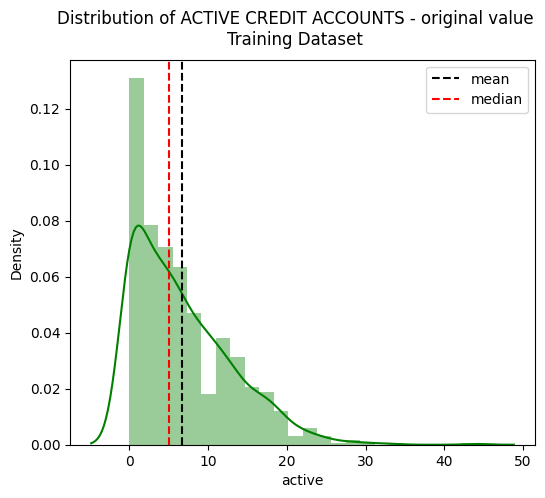

In [110]:
# Print the statistical information and histogram plot before data binning
x = df_train['active']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - original value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [111]:
# Divide the `active` feature into the categories
df_train['active_bin'] = pd.cut(df_train['active'] , bins=bins, labels=labels, include_lowest=True).astype(int)

# Check the binning result and compare it with the original `active` value
df_train[['active', 'active_bin']].tail(10)

,active,active_bin
894,0,0
895,3,1
896,3,1
897,2,1
898,11,3
899,0,0
900,3,1
901,2,1
902,3,1
903,4,1


count    904.000000
mean       1.800885
std        1.179447
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: active_bin, dtype: float64
Median: 2.0


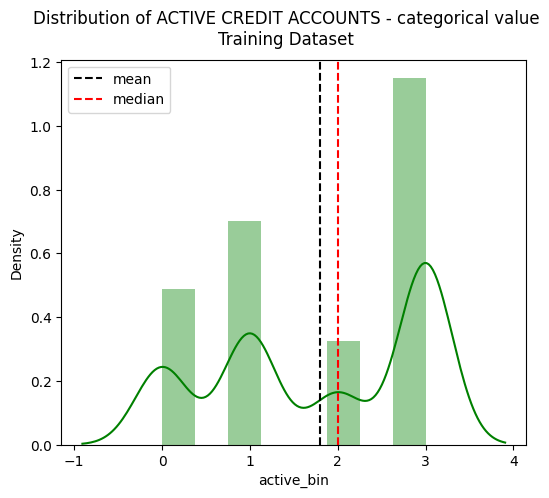

In [112]:
# Print the statistical information and histogram plot after data binning
x = df_train['active_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - categorical value\nTraining Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [113]:
# Save the updated dataset
joblib.dump(df_train, pkl_folder + "df_train.pkl")

['/root/ml_process_feb23/data/processed/df_train.pkl']

#### Validation Data

count    186.000000
mean       7.543011
std        6.814990
min        0.000000
25%        2.000000
50%        6.500000
75%       11.000000
max       46.000000
Name: active, dtype: float64
Median: 6.5


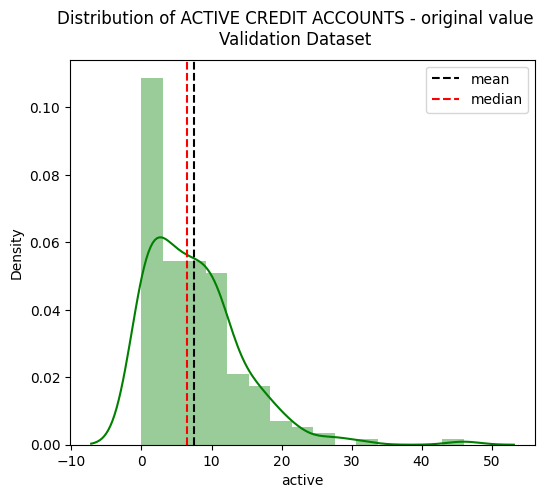

In [114]:
# Print the statistical information and histogram plot before data binning
x = df_valid['active']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - original value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [115]:
# Divide the `active` feature into the categories
df_valid['active_bin'] = pd.cut(df_valid['active'] , bins=bins, labels=labels, include_lowest=True).astype(int)

# Check the binning result and compare it with the original `active` value
df_valid[['active', 'active_bin']].tail(10)

,active,active_bin
176,4,1
177,0,0
178,8,3
179,12,3
180,16,3
181,13,3
182,5,2
183,22,3
184,0,0
185,2,1


count    186.000000
mean       1.956989
std        1.166320
min        0.000000
25%        1.000000
50%        2.500000
75%        3.000000
max        3.000000
Name: active_bin, dtype: float64
Median: 2.5


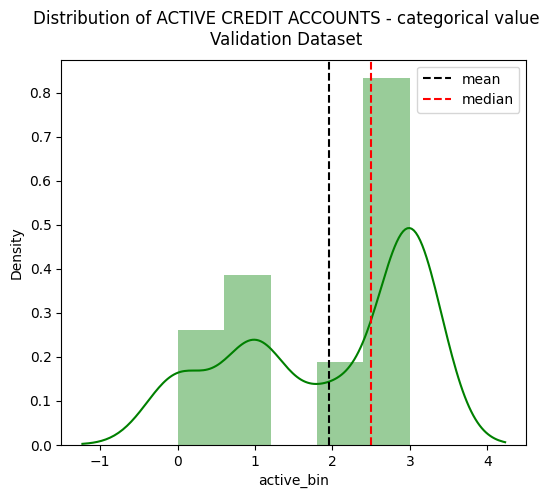

In [116]:
# Print the statistical information and histogram plot after data binning
x = df_valid['active_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - categorical value\nValidation Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [117]:
# Save the updated dataset
joblib.dump(df_valid, pkl_folder + "df_valid.pkl")

['/root/ml_process_feb23/data/processed/df_valid.pkl']

#### Testing Data

count    222.000000
mean       7.531532
std        6.005005
min        0.000000
25%        3.000000
50%        7.000000
75%       11.000000
max       32.000000
Name: active, dtype: float64
Median: 7.0


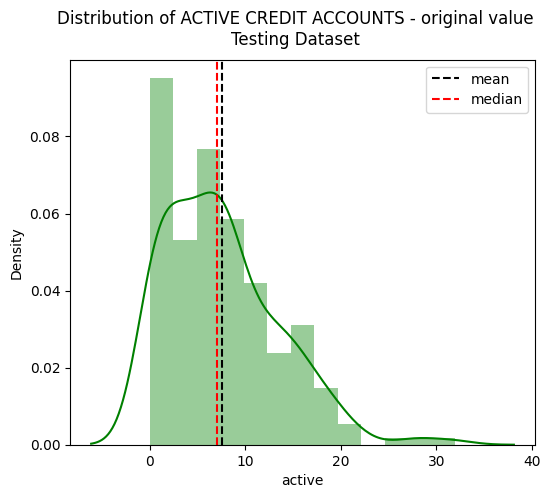

In [118]:
# Print the statistical information and histogram plot before data binning
x = df_test['active']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - original value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [119]:
# Divide the `active` feature into the categories
df_test['active_bin'] = pd.cut(df_test['active'] , bins=bins, labels=labels, include_lowest=True).astype(int)

# Check the binning result and compare it with the original `active` value
df_test[['active', 'active_bin']].tail(10)

,active,active_bin
212,1,1
213,17,3
214,0,0
215,12,3
216,7,3
217,5,2
218,14,3
219,14,3
220,8,3
221,0,0


count    222.000000
mean       2.054054
std        1.103986
min        0.000000
25%        1.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: active_bin, dtype: float64
Median: 3.0


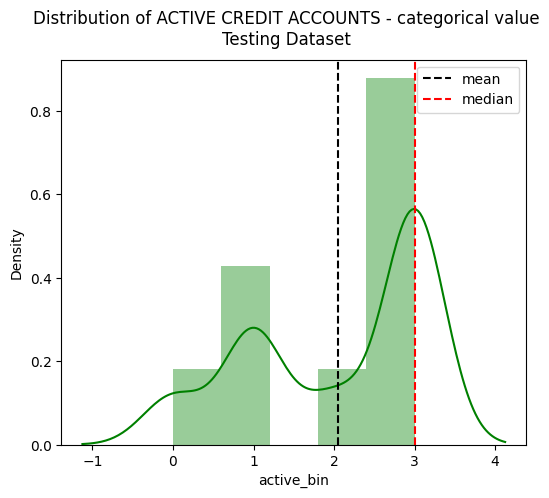

In [120]:
# Print the statistical information and histogram plot after data binning
x = df_test['active_bin']

fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(f"Distribution of ACTIVE CREDIT ACCOUNTS - categorical value\nTesting Dataset")
sns.distplot(x, axlabel=x.name, color = "green")
line1 = plt.axvline(x.mean(), color="k", linestyle="--", label = "mean")
line2 = plt.axvline(np.median(x), color="r", linestyle="--", label = "median")
first_legend = plt.legend(handles=[line1,line2], loc=1)

ax.legend()
fig.show()
print(x.describe())
print("Median:", x.median())

In [121]:
# Save the updated dataset
joblib.dump(df_test, pkl_folder + "df_test.pkl")

['/root/ml_process_feb23/data/processed/df_test.pkl']

# Feature Engineering


## Value Division on the `log_income` Feature

The `log_income` feature values are annual while the `log_expenditure` feature values are monthly, and to make their values conform, I decide to divide the `log_income` feature values by 12.


### Training Data


In [122]:
# Divide the feature value into monthly
df_train['income_log'] = df_train['income_log'] / 12

# Save the updated dataset
joblib.dump(df_train, pkl_folder + "df_train.pkl")



['/root/ml_process_feb23/data/processed/df_train.pkl']

### Validation Data 


In [123]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            186 non-null    int64  
 1   reports          186 non-null    int64  
 2   age              186 non-null    float64
 3   share            186 non-null    float64
 4   owner            186 non-null    int64  
 5   selfemp          186 non-null    int64  
 6   dependents       186 non-null    int64  
 7   majorcards       186 non-null    int64  
 8   active           186 non-null    int64  
 9   card             186 non-null    int64  
 10  income_log       186 non-null    float64
 11  expenditure_log  186 non-null    float64
 12  months_log       186 non-null    float64
 13  age_bin          186 non-null    int64  
 14  reports_bin      186 non-null    int64  
 15  dependents_bin   186 non-null    int64  
 16  active_bin       186 non-null    int64  
dtypes: float64(5), i

In [124]:
# Divide the feature value into monthly
df_valid['income_log'] = df_valid['income_log'] / 12

# Save the updated dataset
joblib.dump(df_valid, pkl_folder + "df_valid.pkl")

['/root/ml_process_feb23/data/processed/df_valid.pkl']

### Testing Data

In [125]:
# Divide the feature value into monthly
df_test['income_log'] = df_test['income_log'] / 12

# Save the updated dataset
joblib.dump(df_test, pkl_folder + "df_test.pkl")

['/root/ml_process_feb23/data/processed/df_test.pkl']

## Data Balancing

The dependent variable is imbalance, it has an uneven distribution of observations.

This means that a dataset is biased towards a class in the dataset. If the dataset is biased towards one class, an algorithm trained on the same data will be biased towards the same class.

In [126]:
# Recheck the target data distribution
print(f"y_train value counts\n{df_train.card.value_counts()}")

y_train value counts
1    700
0    204
Name: card, dtype: int64


Data balancing treatment will only be applied on the training dataset, there are 3 data balacning methods using the imblearn library, e.g. random undersampling, random oversampling, and SMOTE.

In [127]:
# Create instance for random under sampling function
rus = RandomUnderSampler(random_state = 46)

# Create instance for random over  sampling function
ros = RandomOverSampler(random_state = 85)

# Create instance for SMOTE function
smote = SMOTE(random_state = 1205)

In [128]:
# execute the data balancing function
x_rus, y_rus = rus.fit_resample(df_train.drop('card', axis = 1), df_train.card)
df_train_rus = pd.concat([x_rus, y_rus], axis = 1)

x_ros, y_ros = ros.fit_resample(df_train.drop('card', axis = 1), df_train.card)
df_train_ros = pd.concat([x_ros, y_ros], axis = 1) 

x_smote, y_smote = smote.fit_resample(df_train.drop('card', axis = 1), df_train.card)
df_train_smote = pd.concat([x_smote, y_smote], axis = 1)

# check the dependent variable distribution after data balancing
print(f"balanced y_train value counts with random undersampler \n{df_train_rus.card.value_counts()}")
print(f"balanced y_train value counts with random oversampler \n{df_train_ros.card.value_counts()}")
print(f"balanced y_train value counts with SMOTE \n{df_train_smote.card.value_counts()}")

# Save the updated dataset as the new pickles
joblib.dump(df_train_rus, pkl_folder + "df_train_rus.pkl")
joblib.dump(df_train_ros, pkl_folder + "df_train_ros.pkl")
joblib.dump(df_train_smote, pkl_folder + "df_train_smote.pkl")

balanced y_train value counts with random undersampler 
0    204
1    204
Name: card, dtype: int64
balanced y_train value counts with random oversampler 
1    700
0    700
Name: card, dtype: int64
balanced y_train value counts with SMOTE 
1    700
0    700
Name: card, dtype: int64


['/root/ml_process_feb23/data/processed/df_train_smote.pkl']

# Modelling

## Load the Datasets

In [129]:
df_train = joblib.load(pkl_folder + "df_train.pkl")
x_train = df_train.drop(['card'], axis = 1)
y_train = df_train['card']

df_train_rus = joblib.load(pkl_folder + "df_train_rus.pkl")
x_train_rus = df_train_rus.drop(['card'], axis = 1)
y_train_rus = df_train_rus['card']

df_train_ros = joblib.load(pkl_folder + "df_train_ros.pkl")
x_train_ros = df_train_ros.drop(['card'], axis = 1)
y_train_ros = df_train_ros['card']

df_train_smote = joblib.load(pkl_folder + "df_train_smote.pkl")
x_train_smote = df_train_smote.drop(['card'], axis = 1)
y_train_smote = df_train_smote['card']

df_valid = joblib.load(pkl_folder + "df_valid.pkl")
x_valid = df_valid.drop(['card'], axis = 1)
y_valid = df_valid['card']

df_test = joblib.load(pkl_folder + "df_test.pkl")
x_test = df_test.drop(['card'], axis = 1)
y_test = df_test['card']

### Selecting features to be trained

In [130]:
x_test.columns.values

array(['index', 'reports', 'age', 'share', 'owner', 'selfemp',
       'dependents', 'majorcards', 'active', 'income_log',
       'expenditure_log', 'months_log', 'age_bin', 'reports_bin',
       'dependents_bin', 'active_bin'], dtype=object)

In [131]:
# Create instances for some binned features and its original value
bins = ['age_bin', 'reports_bin', 'dependents_bin', 'active_bin']
ori_value = ['age', 'reports', 'dependents', 'active']

For the **baseline model**, I will not include the binned features.

In [132]:
# Create the independent variables for baseline model
x_train_base = x_train.drop(bins, axis = 1)
x_train_rus_base = x_train_rus.drop(bins, axis = 1)
x_train_ros_base = x_train_ros.drop(bins, axis = 1)
x_train_smote_base = x_train_smote.drop(bins, axis = 1)
x_valid_base = x_valid.drop(bins, axis = 1)
x_test_base = x_test.drop(bins, axis = 1)


For the **alternative model**, I use the binned features.

In [133]:
# Create the independent variables for alternative model
x_train_bin = x_train.drop(ori_value, axis = 1)
x_train_rus_bin = x_train_rus.drop(ori_value, axis = 1)
x_train_ros_bin = x_train_ros.drop(ori_value, axis = 1)
x_train_smote_bin = x_train_smote.drop(ori_value, axis = 1)
x_valid_bin = x_valid.drop(ori_value, axis = 1)
x_test_bin = x_test.drop(ori_value, axis = 1)

## Create Log Template

In [ ]:
def time_stamp():
    return datetime.now()

In [ ]:
def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "accuracy" :[],
        "data_configurations" : [],
    }

    return logger

In [ ]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

# Training and Evaluation

## Create Model Object

Create instance for each algorithm function

In [ ]:
lgr      = LogisticRegression(random_state = 12)      # Logistic regression
svm      = SVC(random_state = 23)                     # Support Vector Machine 
dct      = DecisionTreeClassifier(random_state = 34)  # Decision tree Classifier
rfc      = RandomForestClassifier(random_state = 45)  # Random Forest Classifier
knn      = KNeighborsClassifier()                     # k-Nearest Neighbors CLassifier
xgb      = XGBClassifier(random_state = 67)           # XG Boost Classifier
nb_cat   = CategoricalNB()                            # Categorical Naive Bayes Classifier
nb_gauss = GaussianNB()                               # Gaussian Naive Bayes Classifier

In [ ]:
list_of_model = {
    "imbalanced" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "undersampling" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    }

In [ ]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        start_time = time_stamp()
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["accuracy"].append(performance["accuracy"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

In [ ]:
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["accuracy", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

In [ ]:
def get_best_model(training_log_df, list_of_model):
    model_object = None

    best_model_info = training_log_df.sort_values(["accuracy", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object
    

## Train and Evaluate the Baseline Models

### Original (imbalanced) data

In [ ]:
training_log, list_of_model_imbal = train_eval_model(
    list_of_model["imbalanced"],
    "baseline_model",
    x_train_base,
    y_train,
    "imbalanced",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


In [ ]:
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)

### Balanced with undersampling

In [ ]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "baseline_model",
    x_train_rus_base,
    y_train_rus,
    "undersampling",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  7.59it/s]


In [ ]:
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

### Balanced with oversampling

In [ ]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "baseline_model",
    x_train_ros_base,
    y_train_ros,
    "oversampling",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  6.64it/s]


In [ ]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

### Balanced with SMOTE

In [ ]:
training_log, list_of_model_smote = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_train_smote_base,
    y_train_smote,
    "smote",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


In [ ]:
list_of_model["smote"] = copy.deepcopy(list_of_model_smote)

### Table of models performance

Now let's compare the performance from each algorithm and each dataset.

In [ ]:
training_res_baseline = training_log_to_df(training_log)

100%|██████████| 4/4 [00:00<00:00,  8.55it/s]


In [ ]:
training_res_baseline

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,accuracy,data_configurations
0,baseline_model-RandomForestClassifier,624be8210dbf273b37d87500a5216eb1,0.651896,2023-03-27 10:45:32.885928,"{'0': {'precision': 0.9130434782608695, 'recal...",0.970230,0.978495,imbalanced
1,baseline_model-GaussianNB,619727e050631e96a1382a135b70401e,0.160795,2023-03-27 10:45:34.430893,"{'0': {'precision': 0.9111111111111111, 'recal...",0.962492,0.973118,imbalanced
2,baseline_model-GaussianNB,ee594476c30ce802bcb8d443ab79923c,0.400718,2023-03-27 10:45:44.625698,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,smote
3,baseline_model-XGBClassifier,38d07f71649ac1a65df0ef2927a8fcdd,0.607487,2023-03-27 10:45:33.756546,"{'0': {'precision': 0.9111111111111111, 'recal...",0.962492,0.973118,imbalanced
4,baseline_model-XGBClassifier,fbb5a47e188b9492fb06856615456d97,2.088084,2023-03-27 10:45:42.470012,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,smote
5,baseline_model-SVC,854b14b06c1a86b5ef7ba5d2d2795e1b,0.009679,2023-03-27 10:45:36.342923,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling
6,baseline_model-SVC,cc9f25c504a4d86dc0dc7695ff9449eb,0.011110,2023-03-27 10:45:39.709099,"{'0': {'precision': 0.8913043478260869, 'recal...",0.955346,0.967742,smote
7,baseline_model-DecisionTreeClassifier,0167a5bc29df12dcc95d34d319ea3532,0.012235,2023-03-27 10:45:36.389804,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling
8,baseline_model-DecisionTreeClassifier,932da3db9f3def524b2e2b025d18779b,0.033347,2023-03-27 10:45:39.737924,"{'0': {'precision': 0.8913043478260869, 'recal...",0.955346,0.967742,smote
9,baseline_model-GaussianNB,445c2aa937b131e329582d047ccb876b,0.081343,2023-03-27 10:45:37.168624,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling


### Interpretation



From the baseline models table, the best model by F1-Score produced by Random Forest Classifier estimator with the original (imbalance) data configuration.

However, I will bring the top 5 model performance to the hyperparameter tuning process to see how their performance improves after the tuning.

## Train and Evaluate the Alternative Models

The binned value features are used in the datasets for this model training process. 

### Original (imbalanced) data


In [ ]:
training_log, list_of_model_imbal = train_eval_model(
    list_of_model["imbalanced"],
    "alternative_model",
    x_train_bin,
    y_train,
    "imbalanced",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


In [ ]:
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)


### Balanced with undersampling


In [ ]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "alternative_model",
    x_train_rus_bin,
    y_train_rus,
    "undersampling",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)


  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  6.40it/s]


### Balanced with oversampling


In [ ]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "alternative_model",
    x_train_ros_bin,
    y_train_ros,
    "oversampling",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  6.74it/s]


In [ ]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)


### Balanced with SMOTE


In [ ]:
training_log, list_of_model_smote = train_eval_model(
    list_of_model["smote"],
    "alternative_model",
    x_train_smote_bin,
    y_train_smote,
    "smote",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["smote"] = copy.deepcopy(list_of_model_smote)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  5.45it/s]


In [ ]:
list_of_model["smote"] = copy.deepcopy(list_of_model_smote)

### Table of models performance

Now let's compare the performance from each algorithm and each dataset.


In [ ]:
training_res_alternative = training_log_to_df(training_log)

100%|██████████| 4/4 [00:00<00:00, 162.83it/s]


In [ ]:
training_res_alternative

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,accuracy,data_configurations
0,alternative_model-DecisionTreeClassifier,537befec9d129a8930c2511315e582e2,0.009333,2023-03-27 10:45:54.082838,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling
1,alternative_model-SVC,2a636c336633ca38ed23b5d7e54f8000,0.016110,2023-03-27 10:45:54.040188,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling
2,alternative_model-GaussianNB,4409038fcc94bfa426cf0f9defa90a7b,0.058891,2023-03-27 10:45:55.054967,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling
3,alternative_model-XGBClassifier,ea123833ee4345fe5eee20c2e8647a05,0.086210,2023-03-27 10:45:54.912049,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling
4,alternative_model-LogisticRegression,4eac57853bd8637063311e144fd64b0b,0.104633,2023-03-27 10:45:55.929411,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,oversampling
5,alternative_model-LogisticRegression,3b3de335e9bb537ebb12f234c2821588,0.108747,2023-03-27 10:45:48.909341,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,imbalanced
6,alternative_model-LogisticRegression,4c7c1dbe804def0459cc837ded1f08c8,0.147943,2023-03-27 10:45:57.751465,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,smote
7,alternative_model-GaussianNB,573ef0710e15ad50a360eeae4523dc6e,0.164511,2023-03-27 10:45:56.934935,"{'0': {'precision': 0.9090909090909091, 'recal...",0.954627,0.967742,oversampling
8,alternative_model-XGBClassifier,2fd72f693adfdca37ea2f30127b7555f,0.179694,2023-03-27 10:45:56.679986,"{'0': {'precision': 0.9090909090909091, 'recal...",0.954627,0.967742,oversampling
9,alternative_model-RandomForestClassifier,b68ac49796d5d27ed23448bd051e5636,0.469493,2023-03-27 10:45:56.105044,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,oversampling


### Interpretation

From the alternative models table, the best model is resulted from the same algorithm with the best models in the baseline models table.

So the tuning will be using the same parameters, and will compare them together to get the best of the best model.

In [ ]:
best_model_alternative = training_res_alternative.iloc[0]['accuracy']
print(f"The accuracy score of the best model with binned features is: {best_model_alternative}")

The accuracy score of the best model with binned features is: 0.967741935483871


In [ ]:
training_res_baseline.loc[training_res_baseline.accuracy == best_model_alternative].head(1)

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,accuracy,data_configurations
5,baseline_model-SVC,854b14b06c1a86b5ef7ba5d2d2795e1b,0.009679,2023-03-27 10:45:36.342923,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling


The best model in the alternative models resulting F1-Score equals with rank 6 model performance in the baseline models.

So it is proven that the original value performs better than the binned value to classify the target value.

I will not bring any result from alternative models to the hyperparameter tuning process.

## Hyperparameter Tuning

### Create the Paramaters Instances
As mentioned before, I am going to fine-tune the top 5 performers from the baseline models.

In [ ]:
training_res_baseline[['model_name', 'data_configurations']].head(5)

,model_name,data_configurations
0,baseline_model-RandomForestClassifier,imbalanced
1,baseline_model-GaussianNB,imbalanced
2,baseline_model-GaussianNB,smote
3,baseline_model-XGBClassifier,imbalanced
4,baseline_model-XGBClassifier,smote


#### Random Forest

In [ ]:
# Create parameters instance for Random Forest Classifier algorithm
params1 = {
    'n_estimators'      : [50, 100, 200, 300],
    'criterion'         : ['gini', 'entropy', 'log_loss'],
    'max_features'      : ['sqrt', 'log2', None],
    'n_jobs'            : [1, -1]
}

In [ ]:
# Search the best parameters for Random Forest Classifier algorithm
grid_search1 = GridSearchCV(rfc, params1)
random_search1 = RandomizedSearchCV(rfc, params1, random_state = 85)

#### Gaussian Naive Bayes

In [ ]:
# Create parameters instance for Gaussian Naive Bayes algorithm
params3 = {
    'var_smoothing'           : [1e-9, 1e-10, 1e-11, 1e-12]
}

In [ ]:
# Search the best parameters for Gaussian Naive Bayes algorithm
grid_search3 = GridSearchCV(nb_gauss, params3)
random_search3 = RandomizedSearchCV(nb_gauss, params3, random_state = 87)

#### XG Boost

In [ ]:
# Create parameters instance for XG Boost algorithm
params2 = {
    'n_estimators'      : [50, 100, 200, 300],
    'booster'           : ['gbtree', 'dart'],
    'tree_method'       : ['exact', 'approx', 'hist']
}

In [ ]:
# Search the best parameters for XG Boost algorithm
grid_search2 = GridSearchCV(xgb, params2)
random_search2 = RandomizedSearchCV(xgb, params2, random_state = 86)

### Train the Tuned Models



The list in these models will contain both of the default parameters of the algorithm and the tuned ones.

In [ ]:
# Create new list of models

list_of_model = {
    "imbalanced" : [
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": grid_search1.__class__.__name__ + "-" + grid_search1.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search1), "model_uid": ""},
        { "model_name": random_search1.__class__.__name__ + "-" + random_search1.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search1), "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": grid_search2.__class__.__name__ + "-" + grid_search2.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search2), "model_uid": ""},
        { "model_name": random_search2.__class__.__name__ + "-" + random_search2.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search2), "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": nb_gauss, "model_uid": ""},
        { "model_name": grid_search3.__class__.__name__ + "-" + grid_search3.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search3), "model_uid": ""},
        { "model_name": random_search3.__class__.__name__ + "-" + random_search3.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search3), "model_uid": ""}
        ],
    "smote" : [
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": grid_search2.__class__.__name__ + "-" + grid_search2.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search2), "model_uid": ""},
        { "model_name": random_search2.__class__.__name__ + "-" + random_search2.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search2), "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": nb_gauss, "model_uid": ""},
        { "model_name": grid_search3.__class__.__name__ + "-" + grid_search3.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search3), "model_uid": ""},
        { "model_name": random_search3.__class__.__name__ + "-" + random_search3.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search3), "model_uid": ""}
        ],
    }

In [ ]:
training_log, list_of_model_imbal = train_eval_model(
    list_of_model["imbalanced"],
    "baseline_model",
    x_train_base,
    y_train,
    "imbalanced",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_tuned.json"
)
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)

 89%|████████▉ | 8/9 [11:02<01:00, 60.82s/it] /root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
100%|██████████| 9/9 [11:03<00:00, 73.67s/it]


In [ ]:
training_log, list_of_model_smote = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_train_base,
    y_train,
    "smote",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_tuned.json"
)
list_of_model["smote"] = copy.deepcopy(list_of_model_imbal)

 83%|████████▎ | 5/6 [05:19<00:51, 51.56s/it] /root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
100%|██████████| 6/6 [05:19<00:00, 53.33s/it]


### Table of models performance

In [ ]:
training_res_tuned = training_log_to_df(training_log)


100%|██████████| 2/2 [00:00<00:00, 45.06it/s]


In [ ]:
training_res_tuned

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,accuracy,data_configurations
0,baseline_model-RandomForestClassifier,c5350e104e84d100104a5deaf9190236,0.645586,2023-03-27 10:46:09.827695,"{'0': {'precision': 0.9130434782608695, 'recal...",0.970230,0.978495,imbalanced
1,baseline_model-GridSearchCV-RandomForestClassi...,1838efd0cf232cc5a2691dcb125778ba,302.354079,2023-03-27 10:46:10.562519,"{'0': {'precision': 0.9130434782608695, 'recal...",0.970230,0.978495,imbalanced
2,baseline_model-GaussianNB,759da9f0ad48ad37fab609d199902841,0.008939,2023-03-27 11:02:32.591346,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,smote
3,baseline_model-GaussianNB,4cda59e4ba795df7bba0884148fe52e4,0.022207,2023-03-27 10:57:12.218922,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,imbalanced
4,baseline_model-RandomizedSearchCV-GaussianNB,f6632dc11c106f77d0572a2cb90d7414,0.253057,2023-03-27 11:02:32.933096,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,smote
5,baseline_model-XGBClassifier,eb510dda7f352762b5628c1be5686803,0.264161,2023-03-27 10:57:13.233475,"{'0': {'precision': 0.9111111111111111, 'recal...",0.962492,0.973118,smote
6,baseline_model-RandomizedSearchCV-GaussianNB,8095bec8fdeb11dca07ce9c815e762f3,0.271174,2023-03-27 10:57:12.606818,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,imbalanced
7,baseline_model-GridSearchCV-GaussianNB,cc6812925248a8fc4befd256cd22e785,0.302583,2023-03-27 11:02:32.615479,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,smote
8,baseline_model-GridSearchCV-GaussianNB,bb7ffa8cabc2b413f92092dbb5aa852c,0.327059,2023-03-27 10:57:12.258755,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,imbalanced
9,baseline_model-XGBClassifier,36caf14c795e27a04944ce3796a7d3df,0.353437,2023-03-27 10:51:38.958733,"{'0': {'precision': 0.9111111111111111, 'recal...",0.962492,0.973118,imbalanced


### Best Model

As seen in the table above, the hyperparameter tuning did not improve the performance, the best model is still the same with the result in the baseline models table.

The best model now will be saved for further deployment process.

In [ ]:
def get_best_model(training_log_df, list_of_model):
    model_object = None

    best_model_info = training_log_df.sort_values(["accuracy", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object

In [ ]:
best_model = get_best_model(training_res_tuned, list_of_model)
joblib.dump(best_model, "/root/ml_process_feb23/models/best_model.pkl")

['/root/ml_process_feb23/models/best_model.pkl']

In [ ]:
best_model

RandomForestClassifier(random_state=45)

#### Metrics Analysis

After choosing the best model, let's check the confusion matrix and classification report to analyze the model. 

In [ ]:
# Create instance for the predicted target
y_pred = best_model.predict(x_valid_base)

              precision    recall  f1-score   support

           0   0.913043  1.000000  0.954545        42
           1   1.000000  0.972222  0.985915       144

    accuracy                       0.978495       186
   macro avg   0.956522  0.986111  0.970230       186
weighted avg   0.980365  0.978495  0.978832       186



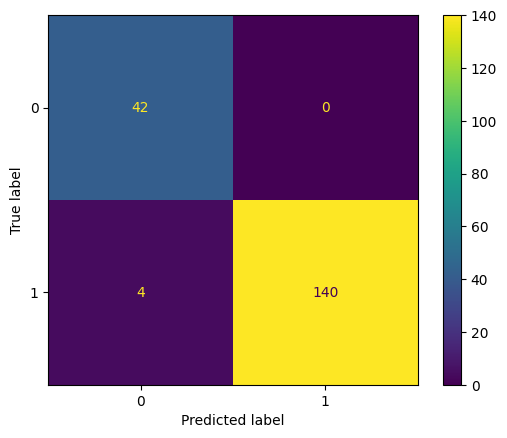

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)
print(classification_report(y_valid, y_pred, digits = 6))

In credit card approval prediction, it is crucial to predict correctly the **accuracy score**, which means the machine learning model is able to predict the approval status of the applications as approved that originally got approved, and vice versa.

If the defect in credit card approval prediction can be kept at a very low level, the credit card issuer will not have a problem handling the credit default status.

In [ ]:
report_on_valid = classification_report(y_valid, y_pred, output_dict = True)
acc_on_valid = report_on_valid["accuracy"]

print(f"The accuracy score on validation datasets is: {round(acc_on_valid, 6)},\nwhich is considered a high score")

The accuracy score on validation datasets is: 0.978495,
which is considered a high score


## Evaluation

Now let's implicate the testing dataset to evaluate the chosen model's performance.

In [ ]:
y_pred_eval = best_model.predict(x_test_base)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        49
           1       1.00      0.98      0.99       173

    accuracy                           0.99       222
   macro avg       0.97      0.99      0.98       222
weighted avg       0.99      0.99      0.99       222



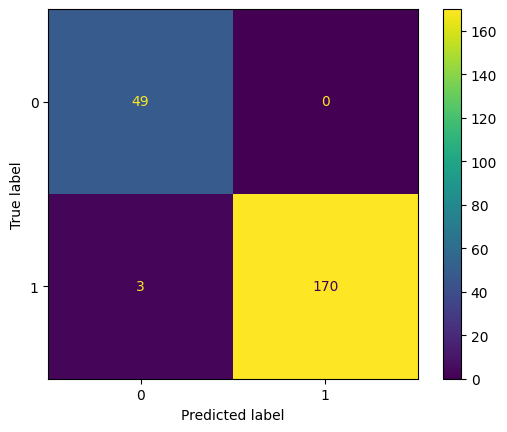

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_eval)
print(classification_report(y_test, y_pred_eval))

In [ ]:
report_on_test = classification_report(y_test, y_pred_eval, output_dict = True, digits = 6)
acc_on_test = report_on_test["accuracy"]

print(f"The accuracy score on testing datasets is: {round(acc_on_test, 6)}")

The accuracy score on testing datasets is: 0.986486


When the model is applied to the testing datasets which contain more data than the validation one, it performs better, the accuracy score improves.